In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\


C:\Users\User\AppData\Local\Temp\ipykernel_99112\1486370924.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17                  7.66               5.43   
647     8000         13.58  1015.12                  8.11               5.32   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-05 03:49:05,342] A new study created in memory with name: no-name-0f09b520-9264-43db-b541-f760de32c910
[I 2025-06-05 03:52:27,640] Trial 0 finished with value: 0.10217642635107041 and parameters: {'lr': 0.2988125455799905, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1429610927494348}. Best is trial 0 with value: 0.10217642635107041.


Cross Validation Accuracies:
[0.14185039699077606, 0.08554685115814209, 0.13140231370925903, 0.08138659596443176, 0.07069597393274307]
Mean Cross Validation Accuracy:
0.10217642635107041
Standard Deviation of Cross Validation Accuracy:
0.0287330998719553


[I 2025-06-05 03:54:35,645] Trial 1 finished with value: 0.0967957004904747 and parameters: {'lr': 0.005348887542782577, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.40897984843295954}. Best is trial 1 with value: 0.0967957004904747.


Cross Validation Accuracies:
[0.14331434667110443, 0.08629363775253296, 0.10159067809581757, 0.08088257908821106, 0.07189726084470749]
Mean Cross Validation Accuracy:
0.0967957004904747
Standard Deviation of Cross Validation Accuracy:
0.02518106155039185


[I 2025-06-05 03:57:43,315] Trial 2 finished with value: 0.09913388192653656 and parameters: {'lr': 0.008833801254279697, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4183718219303295}. Best is trial 1 with value: 0.0967957004904747.


Cross Validation Accuracies:
[0.14325928688049316, 0.090775266289711, 0.10313653945922852, 0.08817274123430252, 0.0703255757689476]
Mean Cross Validation Accuracy:
0.09913388192653656
Standard Deviation of Cross Validation Accuracy:
0.02442541378967073


[I 2025-06-05 03:59:49,272] Trial 3 finished with value: 0.09690319001674652 and parameters: {'lr': 0.014455476645339577, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.32424389770066386}. Best is trial 1 with value: 0.0967957004904747.


Cross Validation Accuracies:
[0.14318105578422546, 0.08884552866220474, 0.10081473737955093, 0.07945083826780319, 0.07222378998994827]
Mean Cross Validation Accuracy:
0.09690319001674652
Standard Deviation of Cross Validation Accuracy:
0.025042061961908457


[I 2025-06-05 04:02:16,931] Trial 4 finished with value: 0.11366060227155686 and parameters: {'lr': 0.0022375640673116246, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2600220295061203}. Best is trial 1 with value: 0.0967957004904747.


Cross Validation Accuracies:
[0.1564415842294693, 0.11063729971647263, 0.11277603358030319, 0.09863681346178055, 0.0898112803697586]
Mean Cross Validation Accuracy:
0.11366060227155686
Standard Deviation of Cross Validation Accuracy:
0.022954910684943684


[I 2025-06-05 04:06:37,880] Trial 5 finished with value: 15.650689220428466 and parameters: {'lr': 0.19470282968578734, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.16427539707483224}. Best is trial 1 with value: 0.0967957004904747.


Cross Validation Accuracies:
[17.912918090820312, 19.040725708007812, 22.183671951293945, 12.191572189331055, 6.924558162689209]
Mean Cross Validation Accuracy:
15.650689220428466
Standard Deviation of Cross Validation Accuracy:
5.429562488499604


[I 2025-06-05 04:08:48,404] Trial 6 finished with value: 1.5260915994644164 and parameters: {'lr': 0.15594437223540927, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.23736219418072924}. Best is trial 1 with value: 0.0967957004904747.


Cross Validation Accuracies:
[1.4022982120513916, 1.1841615438461304, 1.597588300704956, 1.5744258165359497, 1.8719841241836548]
Mean Cross Validation Accuracy:
1.5260915994644164
Standard Deviation of Cross Validation Accuracy:
0.22774133537290128


[I 2025-06-05 04:12:37,268] Trial 7 finished with value: 0.11753735095262527 and parameters: {'lr': 0.054111035458182265, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23555155668931907}. Best is trial 1 with value: 0.0967957004904747.


Cross Validation Accuracies:
[0.1442825198173523, 0.17266249656677246, 0.10121745616197586, 0.0836525484919548, 0.08587173372507095]
Mean Cross Validation Accuracy:
0.11753735095262527
Standard Deviation of Cross Validation Accuracy:
0.03513208179075702


[I 2025-06-05 04:16:16,143] Trial 8 finished with value: 0.0967068001627922 and parameters: {'lr': 0.021562139135218095, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4767729548033942}. Best is trial 8 with value: 0.0967068001627922.


Cross Validation Accuracies:
[0.1437874734401703, 0.08994121104478836, 0.0973077118396759, 0.08105578273534775, 0.07144182175397873]
Mean Cross Validation Accuracy:
0.0967068001627922
Standard Deviation of Cross Validation Accuracy:
0.025083849655586247


[I 2025-06-05 04:19:04,423] Trial 9 finished with value: 0.14339481592178344 and parameters: {'lr': 0.0027507511567952422, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.38385729885715714}. Best is trial 8 with value: 0.0967068001627922.


Cross Validation Accuracies:
[0.18354879319667816, 0.10979288816452026, 0.13725219666957855, 0.158548966050148, 0.12783123552799225]
Mean Cross Validation Accuracy:
0.14339481592178344
Standard Deviation of Cross Validation Accuracy:
0.02549916277865478


[I 2025-06-05 04:22:17,784] Trial 10 finished with value: 9.586346960067749 and parameters: {'lr': 0.9425908986507264, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.49954274125108744}. Best is trial 8 with value: 0.0967068001627922.


Cross Validation Accuracies:
[14.056188583374023, 6.926487445831299, 18.542705535888672, 4.461523532867432, 3.9448297023773193]
Mean Cross Validation Accuracy:
9.586346960067749
Standard Deviation of Cross Validation Accuracy:
5.750847378263425


[I 2025-06-05 04:24:46,177] Trial 11 finished with value: 0.09541953653097153 and parameters: {'lr': 0.010900238569035615, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.48828132156562193}. Best is trial 11 with value: 0.09541953653097153.


Cross Validation Accuracies:
[0.14344054460525513, 0.08147527277469635, 0.10286441445350647, 0.07677983492612839, 0.0725376158952713]
Mean Cross Validation Accuracy:
0.09541953653097153
Standard Deviation of Cross Validation Accuracy:
0.02617978870561221


[I 2025-06-05 04:26:46,828] Trial 12 finished with value: 0.12654679641127586 and parameters: {'lr': 0.03149455784570646, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.49587501887661656}. Best is trial 11 with value: 0.09541953653097153.


Cross Validation Accuracies:
[0.16965875029563904, 0.1530607044696808, 0.05279488489031792, 0.1277732253074646, 0.12944641709327698]
Mean Cross Validation Accuracy:
0.12654679641127586
Standard Deviation of Cross Validation Accuracy:
0.040027201424004434


[I 2025-06-05 04:29:14,380] Trial 13 finished with value: 0.11772591173648835 and parameters: {'lr': 0.02705854780882978, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4470671624998038}. Best is trial 11 with value: 0.09541953653097153.


Cross Validation Accuracies:
[0.1590365767478943, 0.09831587970256805, 0.09740594774484634, 0.13244059681892395, 0.10143055766820908]
Mean Cross Validation Accuracy:
0.11772591173648835
Standard Deviation of Cross Validation Accuracy:
0.024406072380249458


[I 2025-06-05 04:31:11,899] Trial 14 finished with value: 0.22716928720474244 and parameters: {'lr': 0.060417522893052356, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3344424713075719}. Best is trial 11 with value: 0.09541953653097153.


Cross Validation Accuracies:
[0.28266972303390503, 0.23670880496501923, 0.24011877179145813, 0.18473316729068756, 0.1916159689426422]
Mean Cross Validation Accuracy:
0.22716928720474244
Standard Deviation of Cross Validation Accuracy:
0.03578785447660548


[I 2025-06-05 04:33:58,235] Trial 15 finished with value: 0.09363265335559845 and parameters: {'lr': 0.005887598350604116, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.46543255026316843}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.13121409714221954, 0.0826026126742363, 0.0854019969701767, 0.08537471294403076, 0.08356984704732895]
Mean Cross Validation Accuracy:
0.09363265335559845
Standard Deviation of Cross Validation Accuracy:
0.018821392454827036


[I 2025-06-05 04:36:25,863] Trial 16 finished with value: 0.3069943279027939 and parameters: {'lr': 0.0010915273714456346, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3618950896437068}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.1454586237668991, 0.1375168263912201, 0.588189959526062, 0.33094266057014465, 0.33286356925964355]
Mean Cross Validation Accuracy:
0.3069943279027939
Standard Deviation of Cross Validation Accuracy:
0.16439594323414344


[I 2025-06-05 04:39:32,550] Trial 17 finished with value: 0.09652933627367019 and parameters: {'lr': 0.005981642583151894, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.44931989776750236}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14188779890537262, 0.08636635541915894, 0.10142470896244049, 0.08144490420818329, 0.07152291387319565]
Mean Cross Validation Accuracy:
0.09652933627367019
Standard Deviation of Cross Validation Accuracy:
0.02464752416747739


[I 2025-06-05 04:41:47,979] Trial 18 finished with value: 0.10730000287294388 and parameters: {'lr': 0.0026755114744338457, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4432953450681077}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.16442660987377167, 0.11575600504875183, 0.11811742931604385, 0.07344663143157959, 0.06475333869457245]
Mean Cross Validation Accuracy:
0.10730000287294388
Standard Deviation of Cross Validation Accuracy:
0.035800109792374295


[I 2025-06-05 04:43:49,691] Trial 19 finished with value: 0.15737297832965852 and parameters: {'lr': 0.010711025259711553, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.37650396286350335}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.19378717243671417, 0.14481687545776367, 0.18142692744731903, 0.11382190883159637, 0.1530120074748993]
Mean Cross Validation Accuracy:
0.15737297832965852
Standard Deviation of Cross Validation Accuracy:
0.028206224281785864


[I 2025-06-05 04:46:59,106] Trial 20 finished with value: 0.10601834505796433 and parameters: {'lr': 0.001241908587195388, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.30604535661448545}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14391839504241943, 0.0873810201883316, 0.11280108988285065, 0.07991673052310944, 0.1060744896531105]
Mean Cross Validation Accuracy:
0.10601834505796433
Standard Deviation of Cross Validation Accuracy:
0.02241011703682808


[I 2025-06-05 04:49:35,420] Trial 21 finished with value: 0.09692438989877701 and parameters: {'lr': 0.004741575665638342, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.45218629914349684}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.1439942866563797, 0.08758269250392914, 0.10324405878782272, 0.07890930026769638, 0.0708916112780571]
Mean Cross Validation Accuracy:
0.09692438989877701
Standard Deviation of Cross Validation Accuracy:
0.02586514922820565


[I 2025-06-05 04:52:17,736] Trial 22 finished with value: 0.09733615964651107 and parameters: {'lr': 0.005996684554938547, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4628355218446353}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.1443021446466446, 0.0878758579492569, 0.10227666795253754, 0.08044742047786713, 0.07177870720624924]
Mean Cross Validation Accuracy:
0.09733615964651107
Standard Deviation of Cross Validation Accuracy:
0.025526937001922056


[I 2025-06-05 04:54:50,225] Trial 23 finished with value: 0.09593882858753204 and parameters: {'lr': 0.01156170219239674, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4174340675353537}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14365695416927338, 0.08542972803115845, 0.09998561441898346, 0.07874549180269241, 0.07187635451555252]
Mean Cross Validation Accuracy:
0.09593882858753204
Standard Deviation of Cross Validation Accuracy:
0.0256064471075784


[I 2025-06-05 04:57:32,519] Trial 24 finished with value: 0.09727203994989395 and parameters: {'lr': 0.013541486663185219, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4106082100669356}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14380457997322083, 0.08774976432323456, 0.10249210149049759, 0.08282434195280075, 0.06948941200971603]
Mean Cross Validation Accuracy:
0.09727203994989395
Standard Deviation of Cross Validation Accuracy:
0.025549209182664904


[I 2025-06-05 04:59:43,886] Trial 25 finished with value: 0.11984595209360123 and parameters: {'lr': 0.05205723973744328, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.41674819242108424}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.16470392048358917, 0.11395483464002609, 0.11034655570983887, 0.1392841637134552, 0.0709402859210968]
Mean Cross Validation Accuracy:
0.11984595209360123
Standard Deviation of Cross Validation Accuracy:
0.03132663205433831


[I 2025-06-05 05:02:58,916] Trial 26 finished with value: 0.09936317205429077 and parameters: {'lr': 0.022264245272701728, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4802215631111053}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14137312769889832, 0.06937117874622345, 0.10099924355745316, 0.0854758471250534, 0.09959646314382553]
Mean Cross Validation Accuracy:
0.09936317205429077
Standard Deviation of Cross Validation Accuracy:
0.023916291452644504


[I 2025-06-05 05:05:56,476] Trial 27 finished with value: 0.09650033116340637 and parameters: {'lr': 0.0037491574049737966, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.35352507237087083}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14261215925216675, 0.08652794361114502, 0.102095827460289, 0.0808802992105484, 0.07038542628288269]
Mean Cross Validation Accuracy:
0.09650033116340637
Standard Deviation of Cross Validation Accuracy:
0.025231061955912272


[I 2025-06-05 05:08:13,365] Trial 28 finished with value: 0.6179260969161987 and parameters: {'lr': 0.008869490333660284, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3839036035648844}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.6712315082550049, 0.581636905670166, 0.6564841270446777, 0.6018912196159363, 0.5783867239952087]
Mean Cross Validation Accuracy:
0.6179260969161987
Standard Deviation of Cross Validation Accuracy:
0.03864084178094143


[I 2025-06-05 05:10:21,072] Trial 29 finished with value: 0.09804146885871887 and parameters: {'lr': 0.08132384429757163, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.42846454993196814}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14675571024417877, 0.08354119211435318, 0.10532256215810776, 0.08474403619766235, 0.0698438435792923]
Mean Cross Validation Accuracy:
0.09804146885871887
Standard Deviation of Cross Validation Accuracy:
0.02686364623736972


[I 2025-06-05 05:13:10,708] Trial 30 finished with value: 0.1450366273522377 and parameters: {'lr': 0.014977888029083465, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.27896545180054927}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.17875874042510986, 0.1581677943468094, 0.15076425671577454, 0.1403266191482544, 0.09716572612524033]
Mean Cross Validation Accuracy:
0.1450366273522377
Standard Deviation of Cross Validation Accuracy:
0.027041529381421764


[I 2025-06-05 05:15:45,959] Trial 31 finished with value: 0.09626421928405762 and parameters: {'lr': 0.00185523785006483, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.36496747758611725}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.1433887928724289, 0.08604168891906738, 0.10053938627243042, 0.07996754348278046, 0.07138368487358093]
Mean Cross Validation Accuracy:
0.09626421928405762
Standard Deviation of Cross Validation Accuracy:
0.02540915288021341


[I 2025-06-05 05:18:45,029] Trial 32 finished with value: 0.0965537190437317 and parameters: {'lr': 0.0018088283736605643, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.39299968826564385}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14298121631145477, 0.0861399844288826, 0.10173190385103226, 0.08102839440107346, 0.07088709622621536]
Mean Cross Validation Accuracy:
0.0965537190437317
Standard Deviation of Cross Validation Accuracy:
0.025260970690723982


[I 2025-06-05 05:21:40,749] Trial 33 finished with value: 0.09741664230823517 and parameters: {'lr': 0.007795647806709345, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.42762206110184076}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14467185735702515, 0.08668125420808792, 0.1020253598690033, 0.08111415803432465, 0.07259058207273483]
Mean Cross Validation Accuracy:
0.09741664230823517
Standard Deviation of Cross Validation Accuracy:
0.025501562480918276


[I 2025-06-05 05:24:32,729] Trial 34 finished with value: 0.09663563072681428 and parameters: {'lr': 0.0041580161932551485, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.47746213343903154}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14370541274547577, 0.08721961826086044, 0.10048431158065796, 0.08003530651330948, 0.0717335045337677]
Mean Cross Validation Accuracy:
0.09663563072681428
Standard Deviation of Cross Validation Accuracy:
0.0253563588367334


[I 2025-06-05 05:26:42,421] Trial 35 finished with value: 0.09675313681364059 and parameters: {'lr': 0.001693543165867423, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1275442332140057}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14405745267868042, 0.08703209459781647, 0.1008259505033493, 0.0806356742978096, 0.07121451199054718]
Mean Cross Validation Accuracy:
0.09675313681364059
Standard Deviation of Cross Validation Accuracy:
0.02553734022319596


[I 2025-06-05 05:29:50,101] Trial 36 finished with value: 0.09591310322284699 and parameters: {'lr': 0.0032662884120425806, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3484603730797028}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14437393844127655, 0.08248855918645859, 0.10532423853874207, 0.07471770793199539, 0.07266107201576233]
Mean Cross Validation Accuracy:
0.09591310322284699
Standard Deviation of Cross Validation Accuracy:
0.026859419715911565


[I 2025-06-05 05:32:49,096] Trial 37 finished with value: 0.10864600092172623 and parameters: {'lr': 0.015386332444627126, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.335567937034925}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.14995940029621124, 0.1142689436674118, 0.10090389102697372, 0.0980796217918396, 0.08001814782619476]
Mean Cross Validation Accuracy:
0.10864600092172623
Standard Deviation of Cross Validation Accuracy:
0.023364747203405457


[I 2025-06-05 05:34:53,476] Trial 38 finished with value: 0.09679316878318786 and parameters: {'lr': 0.0033828352326466292, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.19221747415547413}. Best is trial 15 with value: 0.09363265335559845.


Cross Validation Accuracies:
[0.1467464566230774, 0.08303463459014893, 0.10708242654800415, 0.07217848300933838, 0.07492384314537048]
Mean Cross Validation Accuracy:
0.09679316878318786
Standard Deviation of Cross Validation Accuracy:
0.02783755454096122


[I 2025-06-05 05:37:51,070] Trial 39 finished with value: 0.09298611283302308 and parameters: {'lr': 0.00623238873645558, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.40114745251885786}. Best is trial 39 with value: 0.09298611283302308.


Cross Validation Accuracies:
[0.14259932935237885, 0.07235213369131088, 0.09644943475723267, 0.08090177923440933, 0.07262788712978363]
Mean Cross Validation Accuracy:
0.09298611283302308
Standard Deviation of Cross Validation Accuracy:
0.026304811041611476


[I 2025-06-05 05:40:40,043] Trial 40 finished with value: 0.0968927875161171 and parameters: {'lr': 0.006875605361301478, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.40035948541961885}. Best is trial 39 with value: 0.09298611283302308.


Cross Validation Accuracies:
[0.14489832520484924, 0.08759532868862152, 0.0997595489025116, 0.08196710795164108, 0.07024362683296204]
Mean Cross Validation Accuracy:
0.0968927875161171
Standard Deviation of Cross Validation Accuracy:
0.02581529153760544


[I 2025-06-05 05:43:39,128] Trial 41 finished with value: 0.09130343496799469 and parameters: {'lr': 0.010492488155874346, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.42439428736791296}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.12274052947759628, 0.08362733572721481, 0.09153321385383606, 0.08294986188411713, 0.07566623389720917]
Mean Cross Validation Accuracy:
0.09130343496799469
Standard Deviation of Cross Validation Accuracy:
0.016501942005062085


[I 2025-06-05 05:47:03,199] Trial 42 finished with value: 0.09822837859392167 and parameters: {'lr': 0.0053088744378577135, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4711302488212055}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.14108169078826904, 0.0856705978512764, 0.10663366317749023, 0.08093828707933426, 0.07681765407323837]
Mean Cross Validation Accuracy:
0.09822837859392167
Standard Deviation of Cross Validation Accuracy:
0.023757606871150663


[I 2025-06-05 05:49:51,258] Trial 43 finished with value: 0.15145475417375565 and parameters: {'lr': 0.019786151104153243, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4997713295925644}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.1630915105342865, 0.18291138112545013, 0.13185954093933105, 0.12081823498010635, 0.1585931032896042]
Mean Cross Validation Accuracy:
0.15145475417375565
Standard Deviation of Cross Validation Accuracy:
0.02235378355392023


[I 2025-06-05 05:52:34,893] Trial 44 finished with value: 0.09817292392253876 and parameters: {'lr': 0.003159838054386193, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3444903938378239}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.15149645507335663, 0.07994307577610016, 0.10533634573221207, 0.07946884632110596, 0.07461989670991898]
Mean Cross Validation Accuracy:
0.09817292392253876
Standard Deviation of Cross Validation Accuracy:
0.028745881651661292


[I 2025-06-05 05:54:57,872] Trial 45 finished with value: 0.11382784992456436 and parameters: {'lr': 0.00902729771717726, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3134769288277121}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.13443920016288757, 0.15759678184986115, 0.07289363443851471, 0.07693370431661606, 0.12727592885494232]
Mean Cross Validation Accuracy:
0.11382784992456436
Standard Deviation of Cross Validation Accuracy:
0.033341223627949244


[I 2025-06-05 05:57:20,166] Trial 46 finished with value: 3.9925725936889647 and parameters: {'lr': 0.5290223886999698, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4359291857459395}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[3.5579111576080322, 4.5311174392700195, 2.9657888412475586, 6.078426837921143, 2.8296186923980713]
Mean Cross Validation Accuracy:
3.9925725936889647
Standard Deviation of Cross Validation Accuracy:
1.2030374635650058


[I 2025-06-05 06:00:18,360] Trial 47 finished with value: 0.25782043039798735 and parameters: {'lr': 0.0423785411135311, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.46058547200653355}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.2683852016925812, 0.17147885262966156, 0.28241166472435, 0.28838175535202026, 0.27844467759132385]
Mean Cross Validation Accuracy:
0.25782043039798735
Standard Deviation of Cross Validation Accuracy:
0.043659054971363825


[I 2025-06-05 06:03:41,034] Trial 48 finished with value: 0.29644711017608644 and parameters: {'lr': 0.00458159895966238, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.39883024565171876}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.22571635246276855, 0.28634101152420044, 0.3358142673969269, 0.3163856863975525, 0.31797823309898376]
Mean Cross Validation Accuracy:
0.29644711017608644
Standard Deviation of Cross Validation Accuracy:
0.03877082011093453


[I 2025-06-05 06:05:57,364] Trial 49 finished with value: 0.12140704691410065 and parameters: {'lr': 0.018114194710139617, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.48610495500980777}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.1752346158027649, 0.10796729475259781, 0.10017312318086624, 0.08133512735366821, 0.14232507348060608]
Mean Cross Validation Accuracy:
0.12140704691410065
Standard Deviation of Cross Validation Accuracy:
0.033383337761314774


[I 2025-06-05 06:08:10,036] Trial 50 finished with value: 0.10583994090557099 and parameters: {'lr': 0.0026784188516970424, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2923932407551705}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.13661111891269684, 0.09084884822368622, 0.10859798640012741, 0.09393545240163803, 0.09920629858970642]
Mean Cross Validation Accuracy:
0.10583994090557099
Standard Deviation of Cross Validation Accuracy:
0.016522270592193005


[I 2025-06-05 06:11:14,025] Trial 51 finished with value: 0.09534330517053605 and parameters: {'lr': 0.012089997166032224, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4277313981534077}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.13196127116680145, 0.07729687541723251, 0.10655366629362106, 0.0778806284070015, 0.08302408456802368]
Mean Cross Validation Accuracy:
0.09534330517053605
Standard Deviation of Cross Validation Accuracy:
0.021208156605681688


[I 2025-06-05 06:14:22,030] Trial 52 finished with value: 0.10130006521940231 and parameters: {'lr': 0.01088147660179452, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.37086923336321076}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.1330496370792389, 0.0962265133857727, 0.10605744272470474, 0.09851595014333725, 0.07265078276395798]
Mean Cross Validation Accuracy:
0.10130006521940231
Standard Deviation of Cross Validation Accuracy:
0.019416186876871647


[I 2025-06-05 06:17:30,908] Trial 53 finished with value: 0.09510712921619416 and parameters: {'lr': 0.007038247144416123, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4358297572340797}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.1386624574661255, 0.08445600420236588, 0.10295547544956207, 0.07748163491487503, 0.0719800740480423]
Mean Cross Validation Accuracy:
0.09510712921619416
Standard Deviation of Cross Validation Accuracy:
0.024156276003286837


[I 2025-06-05 06:21:05,202] Trial 54 finished with value: 0.09733633548021317 and parameters: {'lr': 0.006897579879015903, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4556379813148002}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.14479167759418488, 0.09149283170700073, 0.09784899652004242, 0.08457215130329132, 0.06797602027654648]
Mean Cross Validation Accuracy:
0.09733633548021317
Standard Deviation of Cross Validation Accuracy:
0.025734690048277043


[I 2025-06-05 06:23:57,770] Trial 55 finished with value: 0.14587910771369933 and parameters: {'lr': 0.02609106127867784, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4417373045867631}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.15134884417057037, 0.11701670289039612, 0.13534969091415405, 0.20472513139247894, 0.12095516920089722]
Mean Cross Validation Accuracy:
0.14587910771369933
Standard Deviation of Cross Validation Accuracy:
0.03180528968905593


[I 2025-06-05 06:26:39,468] Trial 56 finished with value: 0.12427996098995209 and parameters: {'lr': 0.009612385452930177, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.46635239821800045}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.14708572626113892, 0.15544922649860382, 0.14334027469158173, 0.10122720152139664, 0.07429737597703934]
Mean Cross Validation Accuracy:
0.12427996098995209
Standard Deviation of Cross Validation Accuracy:
0.03125575186760335


[I 2025-06-05 06:28:51,116] Trial 57 finished with value: 0.09761420339345932 and parameters: {'lr': 0.012799887315899787, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.43101470541566733}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.15221183001995087, 0.08590693026781082, 0.10457547008991241, 0.06725181639194489, 0.07812497019767761]
Mean Cross Validation Accuracy:
0.09761420339345932
Standard Deviation of Cross Validation Accuracy:
0.029893561401387925


[I 2025-06-05 06:31:49,343] Trial 58 finished with value: 0.21096578538417815 and parameters: {'lr': 0.033012219233111435, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.48759617222045376}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.2977530062198639, 0.21484477818012238, 0.22989583015441895, 0.1814689189195633, 0.1308663934469223]
Mean Cross Validation Accuracy:
0.21096578538417815
Standard Deviation of Cross Validation Accuracy:
0.05512058163779813


[I 2025-06-05 06:35:02,938] Trial 59 finished with value: 0.3834466993808746 and parameters: {'lr': 0.005656743889756643, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.410654588084057}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.3665471076965332, 0.4581564962863922, 0.37141773104667664, 0.35536521673202515, 0.36574694514274597]
Mean Cross Validation Accuracy:
0.3834466993808746
Standard Deviation of Cross Validation Accuracy:
0.0377192179128732


[I 2025-06-05 06:37:12,368] Trial 60 finished with value: 0.13281891345977784 and parameters: {'lr': 0.007519805558253675, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4497884508066552}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.12419883906841278, 0.19921386241912842, 0.16461984813213348, 0.08836951851844788, 0.0876924991607666]
Mean Cross Validation Accuracy:
0.13281891345977784
Standard Deviation of Cross Validation Accuracy:
0.043602835582102234


[I 2025-06-05 06:40:32,542] Trial 61 finished with value: 0.09571405351161957 and parameters: {'lr': 0.004010395599925646, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.39010779269596874}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.14273589849472046, 0.08553190529346466, 0.10001306235790253, 0.08375171571969986, 0.06653768569231033]
Mean Cross Validation Accuracy:
0.09571405351161957
Standard Deviation of Cross Validation Accuracy:
0.02579755604543686


[I 2025-06-05 06:43:47,482] Trial 62 finished with value: 0.10097775459289551 and parameters: {'lr': 0.00441807415358143, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.38425125707319063}. Best is trial 41 with value: 0.09130343496799469.


Cross Validation Accuracies:
[0.14342662692070007, 0.09222369641065598, 0.11269921064376831, 0.08233661204576492, 0.07420262694358826]
Mean Cross Validation Accuracy:
0.10097775459289551
Standard Deviation of Cross Validation Accuracy:
0.024820686874508405


[I 2025-06-05 06:46:37,965] Trial 63 finished with value: 0.0890639677643776 and parameters: {'lr': 0.0022010975910560578, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4219890267436188}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.12212546169757843, 0.08569703996181488, 0.09847107529640198, 0.07551302760839462, 0.06351323425769806]
Mean Cross Validation Accuracy:
0.0890639677643776
Standard Deviation of Cross Validation Accuracy:
0.020146266244057253


[I 2025-06-05 06:49:19,290] Trial 64 finished with value: 0.17715099155902864 and parameters: {'lr': 0.0013730841955137381, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4180852081647747}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.25729215145111084, 0.09315085411071777, 0.14709435403347015, 0.20167240500450134, 0.18654519319534302]
Mean Cross Validation Accuracy:
0.17715099155902864
Standard Deviation of Cross Validation Accuracy:
0.054902788273955186


[I 2025-06-05 06:51:56,459] Trial 65 finished with value: 0.1069521188735962 and parameters: {'lr': 0.017671494717923644, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.43760605734769614}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14407899975776672, 0.11984290927648544, 0.10396455973386765, 0.10009956359863281, 0.06677456200122833]
Mean Cross Validation Accuracy:
0.1069521188735962
Standard Deviation of Cross Validation Accuracy:
0.02535624917467395


[I 2025-06-05 06:54:32,746] Trial 66 finished with value: 0.09241976812481881 and parameters: {'lr': 0.01181692749244496, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.47029470373955296}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14284217357635498, 0.08057381212711334, 0.09632854163646698, 0.0824272409081459, 0.0599270723760128]
Mean Cross Validation Accuracy:
0.09241976812481881
Standard Deviation of Cross Validation Accuracy:
0.02776202453923152


[I 2025-06-05 06:57:34,935] Trial 67 finished with value: 0.09716599062085152 and parameters: {'lr': 0.0023701409765482296, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.40332115756365816}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.13673214614391327, 0.08623672276735306, 0.11177282780408859, 0.08985260128974915, 0.06123565509915352]
Mean Cross Validation Accuracy:
0.09716599062085152
Standard Deviation of Cross Validation Accuracy:
0.025466699532512245


[I 2025-06-05 07:00:19,615] Trial 68 finished with value: 0.09711870402097703 and parameters: {'lr': 0.006313229287721472, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4251015348838932}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14373789727687836, 0.09351028501987457, 0.09962393343448639, 0.07963677495718002, 0.06908462941646576]
Mean Cross Validation Accuracy:
0.09711870402097703
Standard Deviation of Cross Validation Accuracy:
0.02562878547514821


[I 2025-06-05 07:02:55,173] Trial 69 finished with value: 0.09584733992815017 and parameters: {'lr': 0.007860160138970292, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.46950362744928503}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14237633347511292, 0.08465072512626648, 0.10176365822553635, 0.07855179905891418, 0.07189418375492096]
Mean Cross Validation Accuracy:
0.09584733992815017
Standard Deviation of Cross Validation Accuracy:
0.025291119668095236


[I 2025-06-05 07:05:42,783] Trial 70 finished with value: 0.09451943039894103 and parameters: {'lr': 0.01252313238520276, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.449534953586002}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.1426975131034851, 0.08273076266050339, 0.11023256182670593, 0.06942417472600937, 0.0675121396780014]
Mean Cross Validation Accuracy:
0.09451943039894103
Standard Deviation of Cross Validation Accuracy:
0.028517252493094572


[I 2025-06-05 07:08:18,237] Trial 71 finished with value: 0.09663992300629616 and parameters: {'lr': 0.012431982459829531, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4545104173985272}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14823861420154572, 0.09196174144744873, 0.10910532623529434, 0.076652392745018, 0.057241540402173996]
Mean Cross Validation Accuracy:
0.09663992300629616
Standard Deviation of Cross Validation Accuracy:
0.03095619650793065


[I 2025-06-05 07:10:50,981] Trial 72 finished with value: 0.10400956720113755 and parameters: {'lr': 0.015784534996470832, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.44327883606134794}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14951474964618683, 0.06486091762781143, 0.09597321599721909, 0.09945184737443924, 0.11024710536003113]
Mean Cross Validation Accuracy:
0.10400956720113755
Standard Deviation of Cross Validation Accuracy:
0.027304215886003253


[I 2025-06-05 07:13:28,919] Trial 73 finished with value: 0.10036447793245315 and parameters: {'lr': 0.009012721968318841, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.42121836751215214}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14447012543678284, 0.0840638056397438, 0.11672121286392212, 0.08455100655555725, 0.07201623916625977]
Mean Cross Validation Accuracy:
0.10036447793245315
Standard Deviation of Cross Validation Accuracy:
0.02657913224588733


[I 2025-06-05 07:16:03,506] Trial 74 finished with value: 0.13787613660097123 and parameters: {'lr': 0.023250756296289775, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4733729691313135}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.16589248180389404, 0.08628913015127182, 0.14914071559906006, 0.12570694088935852, 0.16235141456127167]
Mean Cross Validation Accuracy:
0.13787613660097123
Standard Deviation of Cross Validation Accuracy:
0.02939440126444609


[I 2025-06-05 07:18:53,127] Trial 75 finished with value: 0.09646188020706177 and parameters: {'lr': 0.004984538966143427, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.41159764165492696}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14430788159370422, 0.08705964684486389, 0.09942063689231873, 0.08114023506641388, 0.07038100063800812]
Mean Cross Validation Accuracy:
0.09646188020706177
Standard Deviation of Cross Validation Accuracy:
0.025695762961709428


[I 2025-06-05 07:22:02,146] Trial 76 finished with value: 0.713578200340271 and parameters: {'lr': 0.011084821505680197, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1908013385625853}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.6994134187698364, 0.735559344291687, 0.7211773991584778, 0.7427139282226562, 0.6690269112586975]
Mean Cross Validation Accuracy:
0.713578200340271
Standard Deviation of Cross Validation Accuracy:
0.026740484464930554


[I 2025-06-05 07:25:02,156] Trial 77 finished with value: 0.1311323344707489 and parameters: {'lr': 0.001017641420507899, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4609300118979365}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.19085367023944855, 0.11544027179479599, 0.1122220903635025, 0.07562170177698135, 0.1615239381790161]
Mean Cross Validation Accuracy:
0.1311323344707489
Standard Deviation of Cross Validation Accuracy:
0.04043650832414238


[I 2025-06-05 07:28:34,990] Trial 78 finished with value: 0.18577406108379363 and parameters: {'lr': 0.0309333465464885, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.43375541939323015}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.19717419147491455, 0.14340415596961975, 0.09551696479320526, 0.18820127844810486, 0.3045737147331238]
Mean Cross Validation Accuracy:
0.18577406108379363
Standard Deviation of Cross Validation Accuracy:
0.06955683194979717


[I 2025-06-05 07:31:41,372] Trial 79 finished with value: 0.10273516476154328 and parameters: {'lr': 0.013789032411540123, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.49068502521788776}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.1503399908542633, 0.08722219616174698, 0.10473953932523727, 0.08028429746627808, 0.09108980000019073]
Mean Cross Validation Accuracy:
0.10273516476154328
Standard Deviation of Cross Validation Accuracy:
0.025101972600664383


[I 2025-06-05 07:34:26,835] Trial 80 finished with value: 0.09776943475008011 and parameters: {'lr': 0.0021988364179150992, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.47910784051085953}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.1591215282678604, 0.07338806241750717, 0.10052717477083206, 0.07334248721599579, 0.08246792107820511]
Mean Cross Validation Accuracy:
0.09776943475008011
Standard Deviation of Cross Validation Accuracy:
0.032239565481996045


[I 2025-06-05 07:36:33,433] Trial 81 finished with value: 0.09649341851472855 and parameters: {'lr': 0.01000846270753968, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24800553153904223}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14197738468647003, 0.0860026478767395, 0.10912761092185974, 0.07911210507154465, 0.06624734401702881]
Mean Cross Validation Accuracy:
0.09649341851472855
Standard Deviation of Cross Validation Accuracy:
0.02666610336964153


[I 2025-06-05 07:38:34,368] Trial 82 finished with value: 0.10611477345228196 and parameters: {'lr': 0.00791532372678136, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.45057769430019373}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.1305420696735382, 0.08744613826274872, 0.14302214980125427, 0.07853979617357254, 0.09102371335029602]
Mean Cross Validation Accuracy:
0.10611477345228196
Standard Deviation of Cross Validation Accuracy:
0.02567288311198667


[I 2025-06-05 07:40:42,378] Trial 83 finished with value: 0.3269379913806915 and parameters: {'lr': 0.12219835922901562, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.48236727813269764}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.3861594796180725, 0.478403240442276, 0.28252312541007996, 0.286813884973526, 0.20079022645950317]
Mean Cross Validation Accuracy:
0.3269379913806915
Standard Deviation of Cross Validation Accuracy:
0.09585905191593583


[I 2025-06-05 07:43:47,400] Trial 84 finished with value: 0.21391215026378632 and parameters: {'lr': 0.006196105638016595, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4643434129252059}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.3166346848011017, 0.2750827968120575, 0.1713608056306839, 0.11317799985408783, 0.19330446422100067]
Mean Cross Validation Accuracy:
0.21391215026378632
Standard Deviation of Cross Validation Accuracy:
0.07304304185039162


[I 2025-06-05 07:45:58,770] Trial 85 finished with value: 0.10861605256795884 and parameters: {'lr': 0.017304422681652113, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4925073397164936}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.1514909863471985, 0.07764279097318649, 0.13326187431812286, 0.09114553034305573, 0.08953908085823059]
Mean Cross Validation Accuracy:
0.10861605256795884
Standard Deviation of Cross Validation Accuracy:
0.02854529525703964


[I 2025-06-05 07:48:57,450] Trial 86 finished with value: 0.09492678195238113 and parameters: {'lr': 0.011757272562051103, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4434269526135626}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14530164003372192, 0.08263470977544785, 0.09589047729969025, 0.08067014068365097, 0.07013694196939468]
Mean Cross Validation Accuracy:
0.09492678195238113
Standard Deviation of Cross Validation Accuracy:
0.026485611416344243


[I 2025-06-05 07:51:54,921] Trial 87 finished with value: 0.09995488673448563 and parameters: {'lr': 0.021067935996535128, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4409126980614965}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14128535985946655, 0.06387121230363846, 0.0773797407746315, 0.11966642737388611, 0.09757169336080551]
Mean Cross Validation Accuracy:
0.09995488673448563
Standard Deviation of Cross Validation Accuracy:
0.027978925030493762


[I 2025-06-05 07:55:08,668] Trial 88 finished with value: 0.09721902161836624 and parameters: {'lr': 0.013244021380647843, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4282086638034277}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14726898074150085, 0.08771254122257233, 0.100506491959095, 0.08016278594732285, 0.07044430822134018]
Mean Cross Validation Accuracy:
0.09721902161836624
Standard Deviation of Cross Validation Accuracy:
0.026884863740563356


[I 2025-06-05 07:58:08,626] Trial 89 finished with value: 0.09898114204406738 and parameters: {'lr': 0.008326357683460857, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4011495051352168}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.1434244066476822, 0.08352968096733093, 0.10656429082155228, 0.08289239555597305, 0.07849493622779846]
Mean Cross Validation Accuracy:
0.09898114204406738
Standard Deviation of Cross Validation Accuracy:
0.024289866017411423


[I 2025-06-05 08:01:15,547] Trial 90 finished with value: 0.1211510181427002 and parameters: {'lr': 0.005176891992263953, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.37598094752460215}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.12451639771461487, 0.1714627593755722, 0.07261676341295242, 0.11880965530872345, 0.11834951490163803]
Mean Cross Validation Accuracy:
0.1211510181427002
Standard Deviation of Cross Validation Accuracy:
0.03134166992375673


[I 2025-06-05 08:03:47,142] Trial 91 finished with value: 0.0969434604048729 and parameters: {'lr': 0.01063727418187454, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.44738078974148215}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14379489421844482, 0.08759729564189911, 0.10148099064826965, 0.08054826408624649, 0.0712958574295044]
Mean Cross Validation Accuracy:
0.0969434604048729
Standard Deviation of Cross Validation Accuracy:
0.025414951613498445


[I 2025-06-05 08:06:36,263] Trial 92 finished with value: 0.10256050676107406 and parameters: {'lr': 0.006913651180473465, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4571556423079075}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14286848902702332, 0.09839712083339691, 0.10713246464729309, 0.08972343802452087, 0.07468102127313614]
Mean Cross Validation Accuracy:
0.10256050676107406
Standard Deviation of Cross Validation Accuracy:
0.022825538593721516


[I 2025-06-05 08:08:46,158] Trial 93 finished with value: 0.09626134932041168 and parameters: {'lr': 0.015601503861046147, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4714177216989487}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14335997402668, 0.08669745922088623, 0.1021968275308609, 0.08090808242559433, 0.06814440339803696]
Mean Cross Validation Accuracy:
0.09626134932041168
Standard Deviation of Cross Validation Accuracy:
0.025966377479308373


[I 2025-06-05 08:10:25,568] Trial 94 finished with value: 0.11335771605372429 and parameters: {'lr': 0.0036494944293234154, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.42098416200340005}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.1891888678073883, 0.06027698889374733, 0.11308024823665619, 0.09675396978855133, 0.10748850554227829]
Mean Cross Validation Accuracy:
0.11335771605372429
Standard Deviation of Cross Validation Accuracy:
0.042138192136290234


[I 2025-06-05 08:13:43,166] Trial 95 finished with value: 0.09712846279144287 and parameters: {'lr': 0.012347989366934856, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.43637197846150366}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.1418856382369995, 0.08893508464097977, 0.1035081148147583, 0.07863987237215042, 0.07267360389232635]
Mean Cross Validation Accuracy:
0.09712846279144287
Standard Deviation of Cross Validation Accuracy:
0.02470183903594009


[I 2025-06-05 08:16:38,610] Trial 96 finished with value: 0.09650503545999527 and parameters: {'lr': 0.009236275130828735, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.41011330110372507}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.13742224872112274, 0.09384191781282425, 0.10228089243173599, 0.0793120265007019, 0.06966809183359146]
Mean Cross Validation Accuracy:
0.09650503545999527
Standard Deviation of Cross Validation Accuracy:
0.023368749049525024


[I 2025-06-05 08:17:39,284] Trial 97 finished with value: 0.25606375336647036 and parameters: {'lr': 0.038591002682487774, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10408574001006482}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.2561878263950348, 0.23945215344429016, 0.17986854910850525, 0.2583387494087219, 0.34647148847579956]
Mean Cross Validation Accuracy:
0.25606375336647036
Standard Deviation of Cross Validation Accuracy:
0.053404876130546196


[I 2025-06-05 08:19:09,046] Trial 98 finished with value: 0.16209545135498046 and parameters: {'lr': 0.003111062666811989, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.38982802131896993}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.18993735313415527, 0.15530061721801758, 0.17863772809505463, 0.13227637112140656, 0.1543251872062683]
Mean Cross Validation Accuracy:
0.16209545135498046
Standard Deviation of Cross Validation Accuracy:
0.020221487266234062


[I 2025-06-05 08:20:24,301] Trial 99 finished with value: 0.11660184115171432 and parameters: {'lr': 0.023996995578177253, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4794860298159591}. Best is trial 63 with value: 0.0890639677643776.


Cross Validation Accuracies:
[0.14265555143356323, 0.1444961577653885, 0.11760656535625458, 0.09411843121051788, 0.08413249999284744]
Mean Cross Validation Accuracy:
0.11660184115171432
Standard Deviation of Cross Validation Accuracy:
0.02456688839636141
Number of finished trials: 100
Best trial: {'lr': 0.0022010975910560578, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4219890267436188}
Best hyperparameters:  {'lr': 0.0022010975910560578, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4219890267436188}
Fold 1:
Epoch 1/100
19/19 [==============================] - 5s 106ms/step - loss: 0.6831 - val_loss: 0.5055
Epoch 2/100
19/19 [==============================] - 1s 43ms/step - loss: 0.5614 - val_loss: 0.3849
Epoch 3/100
19/19 [==============================] - 1s 44ms/step - loss: 0.3430 - val_loss: 0.1086
Epoch 4/100
19/19 [==============================] - 1s 42ms/step - loss: 0.2467 - val_loss: 0

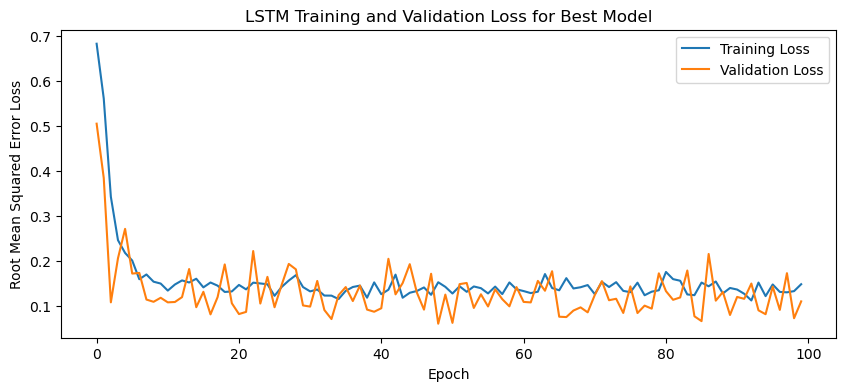

1/1 - 1s - loss: 0.2444 - 891ms/epoch - 891ms/step
Test Loss: 0.24436014890670776
Fold 2:
Epoch 1/100
19/19 [==============================] - 5s 93ms/step - loss: 0.6225 - val_loss: 0.5424
Epoch 2/100
19/19 [==============================] - 1s 41ms/step - loss: 0.5675 - val_loss: 0.5219
Epoch 3/100
19/19 [==============================] - 1s 41ms/step - loss: 0.4099 - val_loss: 0.3949
Epoch 4/100
19/19 [==============================] - 1s 41ms/step - loss: 0.2783 - val_loss: 0.2683
Epoch 5/100
19/19 [==============================] - 1s 41ms/step - loss: 0.2004 - val_loss: 0.2511
Epoch 6/100
19/19 [==============================] - 1s 41ms/step - loss: 0.2277 - val_loss: 0.2187
Epoch 7/100
19/19 [==============================] - 1s 41ms/step - loss: 0.2068 - val_loss: 0.1490
Epoch 8/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1722 - val_loss: 0.2280
Epoch 9/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1744 - val_loss: 0.2476
Epoch 10/1

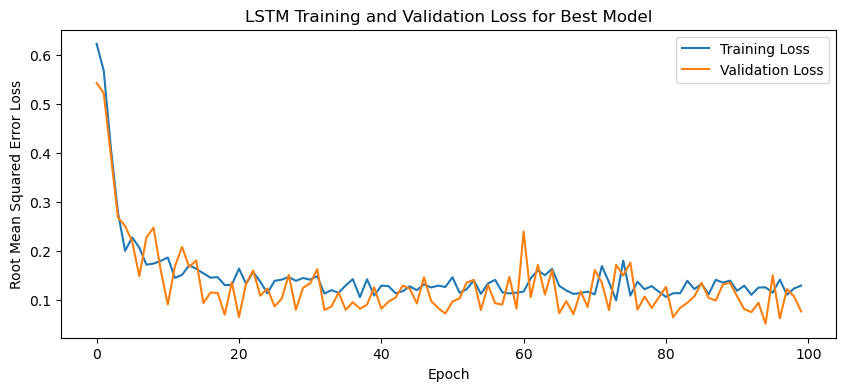

1/1 - 1s - loss: 0.1052 - 910ms/epoch - 910ms/step
Test Loss: 0.10521767288446426
Fold 3:
Epoch 1/100
19/19 [==============================] - 5s 99ms/step - loss: 0.7433 - val_loss: 0.8020
Epoch 2/100
19/19 [==============================] - 1s 42ms/step - loss: 0.4092 - val_loss: 0.2435
Epoch 3/100
19/19 [==============================] - 1s 42ms/step - loss: 0.2220 - val_loss: 0.1532
Epoch 4/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1484 - val_loss: 0.1174
Epoch 5/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1426 - val_loss: 0.1385
Epoch 6/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1387 - val_loss: 0.0597
Epoch 7/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1218 - val_loss: 0.0756
Epoch 8/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1661 - val_loss: 0.1025
Epoch 9/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1221 - val_loss: 0.1756
Epoch 10/1

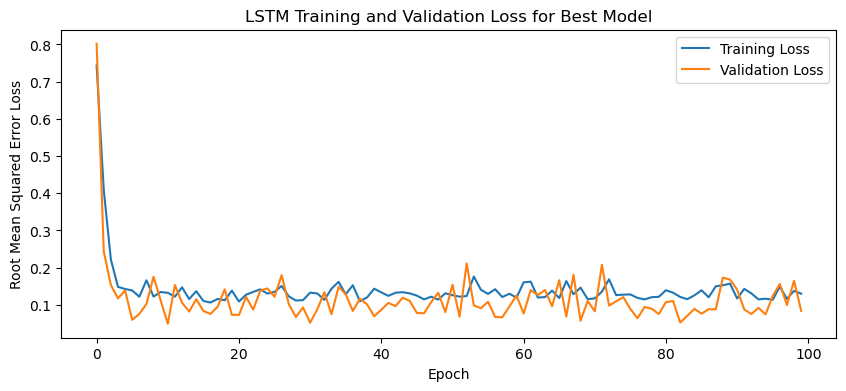

1/1 - 1s - loss: 0.0704 - 1s/epoch - 1s/step
Test Loss: 0.07035476714372635
Fold 4:
Epoch 1/100
20/20 [==============================] - 5s 90ms/step - loss: 0.6436 - val_loss: 0.4853
Epoch 2/100
20/20 [==============================] - 1s 41ms/step - loss: 0.5401 - val_loss: 0.2457
Epoch 3/100
20/20 [==============================] - 1s 41ms/step - loss: 0.2687 - val_loss: 0.3318
Epoch 4/100
20/20 [==============================] - 1s 41ms/step - loss: 0.1766 - val_loss: 0.1247
Epoch 5/100
20/20 [==============================] - 1s 41ms/step - loss: 0.1335 - val_loss: 0.3129
Epoch 6/100
20/20 [==============================] - 1s 41ms/step - loss: 0.1561 - val_loss: 0.1267
Epoch 7/100
20/20 [==============================] - 1s 41ms/step - loss: 0.1454 - val_loss: 0.0959
Epoch 8/100
20/20 [==============================] - 1s 41ms/step - loss: 0.1027 - val_loss: 0.1360
Epoch 9/100
20/20 [==============================] - 1s 42ms/step - loss: 0.1105 - val_loss: 0.1892
Epoch 10/100
20/

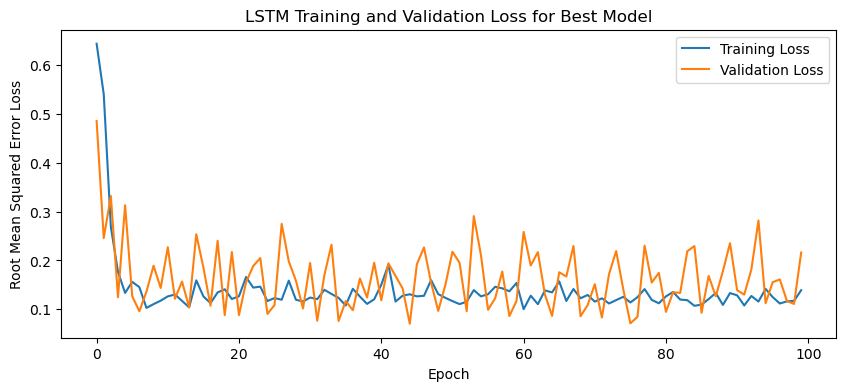

1/1 - 1s - loss: 0.0902 - 854ms/epoch - 854ms/step
Test Loss: 0.09021428972482681
Fold 5:
Epoch 1/100
19/19 [==============================] - 5s 93ms/step - loss: 0.7199 - val_loss: 0.3328
Epoch 2/100
19/19 [==============================] - 1s 41ms/step - loss: 0.4630 - val_loss: 0.4544
Epoch 3/100
19/19 [==============================] - 1s 41ms/step - loss: 0.3308 - val_loss: 0.4368
Epoch 4/100
19/19 [==============================] - 1s 41ms/step - loss: 0.2401 - val_loss: 0.2029
Epoch 5/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1515 - val_loss: 0.1334
Epoch 6/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1322 - val_loss: 0.1880
Epoch 7/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1249 - val_loss: 0.1390
Epoch 8/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1243 - val_loss: 0.3035
Epoch 9/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1206 - val_loss: 0.1161
Epoch 10/1

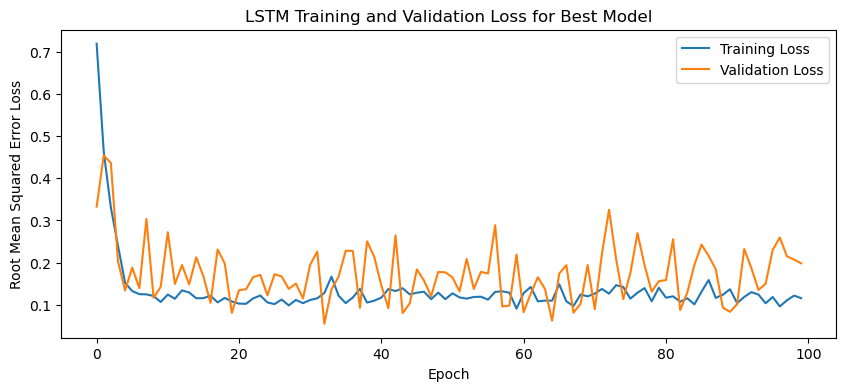

1/1 - 1s - loss: 0.1019 - 1s/epoch - 1s/step
Test Loss: 0.10185179114341736


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

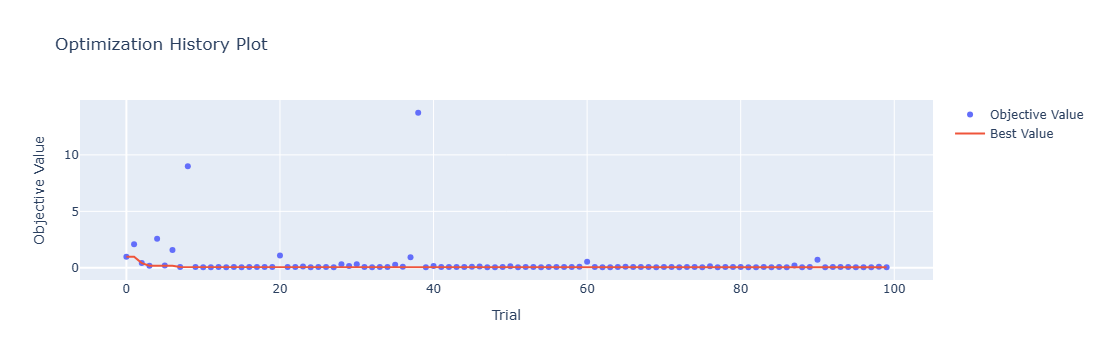

In [4]:
optuna.visualization.plot_optimization_history(study) 

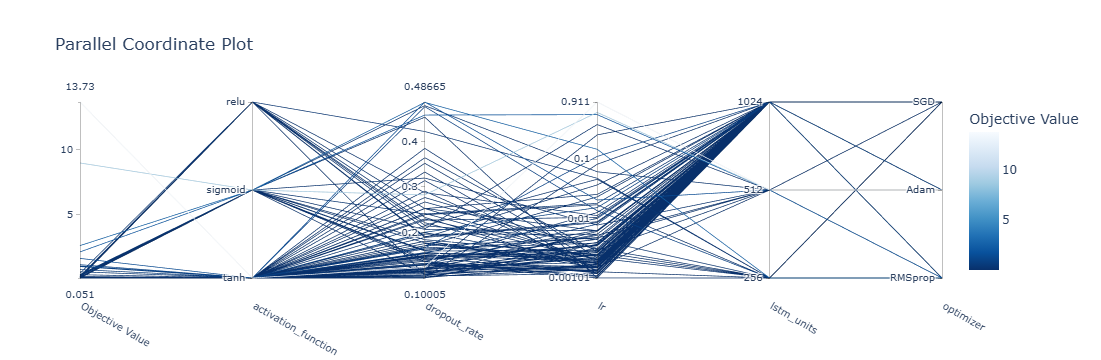

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

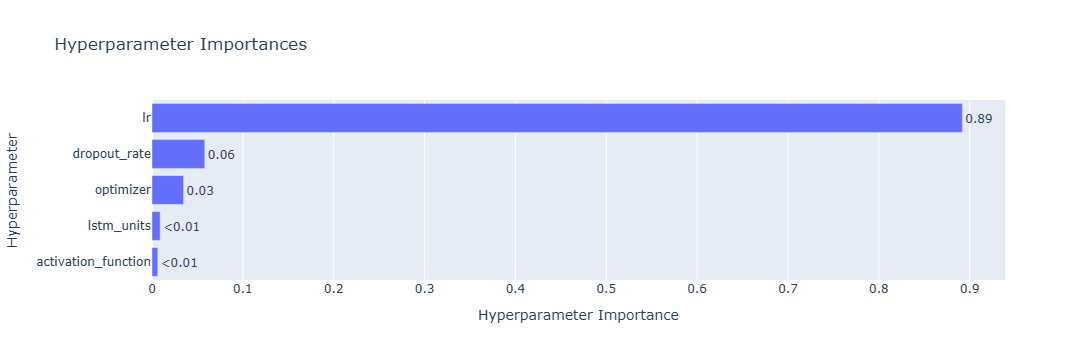

In [6]:
optuna.visualization.plot_param_importances(study)

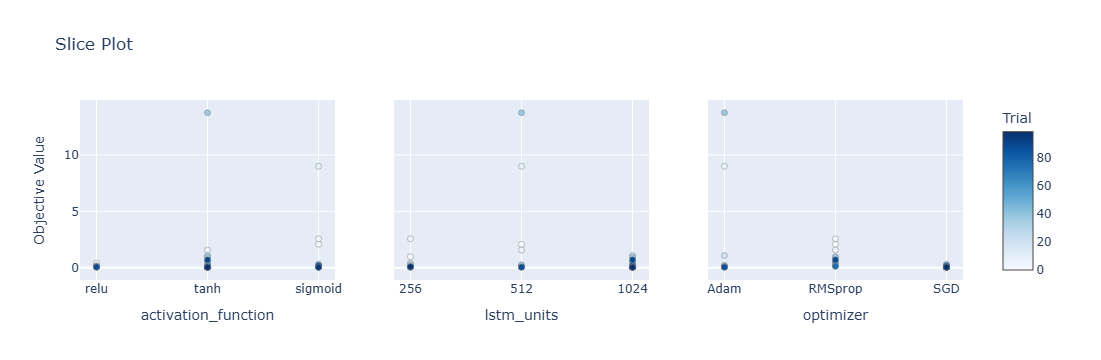

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

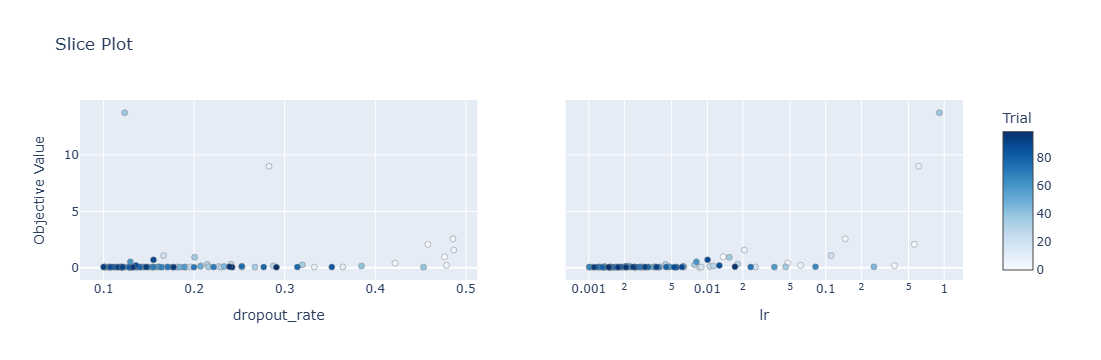

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 7s 154ms/step - loss: 0.6983 - accuracy: 0.3684 - mae: 0.6100 - rmse: 0.6983 - mape: 113.3082 - pearson: 0.1484 - val_loss: 0.7749 - val_accuracy: 0.0000e+00 - val_mae: 0.6288 - val_rmse: 0.7749 - val_mape: 109.9119 - val_pearson: 0.3758
Epoch 2/100
19/19 [==============================] - 1s 66ms/step - loss: 0.4835 - accuracy: 0.1579 - mae: 0.4063 - rmse: 0.4835 - mape: 79.0518 - pearson: 0.4334 - val_loss: 0.2882 - val_accuracy: 0.6667 - val_mae: 0.2136 - val_rmse: 0.2882 - val_mape: 36.1940 - val_pearson: 0.3371
Epoch 3/100
19/19 [==============================] - 1s 50ms/step - loss: 0.3550 - acc

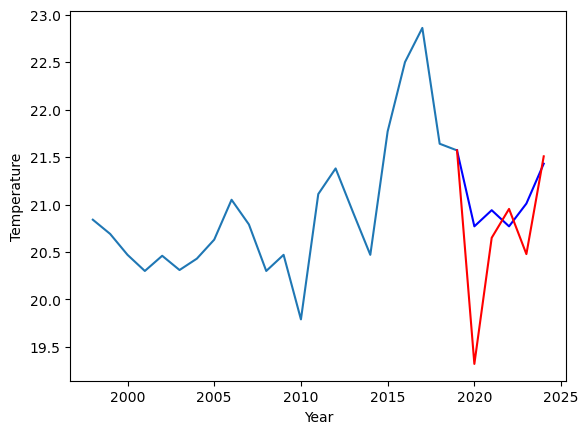

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.52		15.05		-2.47
16.69		16.38		-0.31
16.18		16.68		0.50
16.46		16.21		-0.25
16.29		17.24		0.95


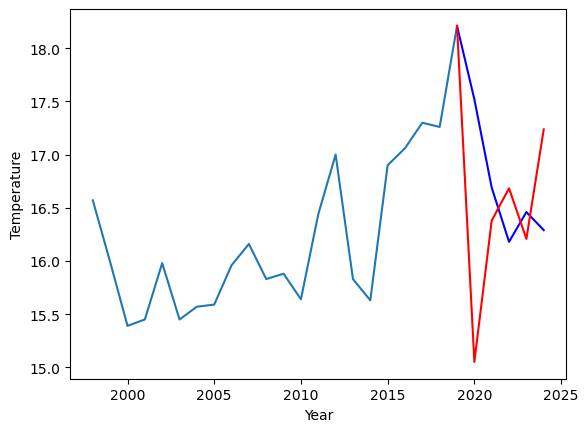

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.77  19.320895
1                1   17.52  15.050900


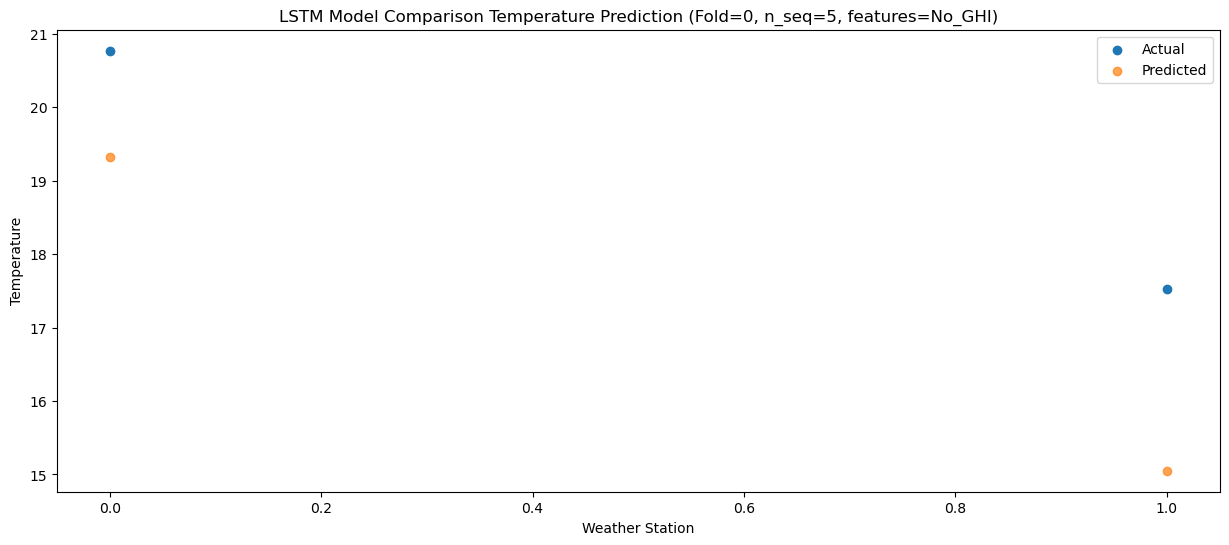

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.94  20.649482
1                1   16.69  16.379494


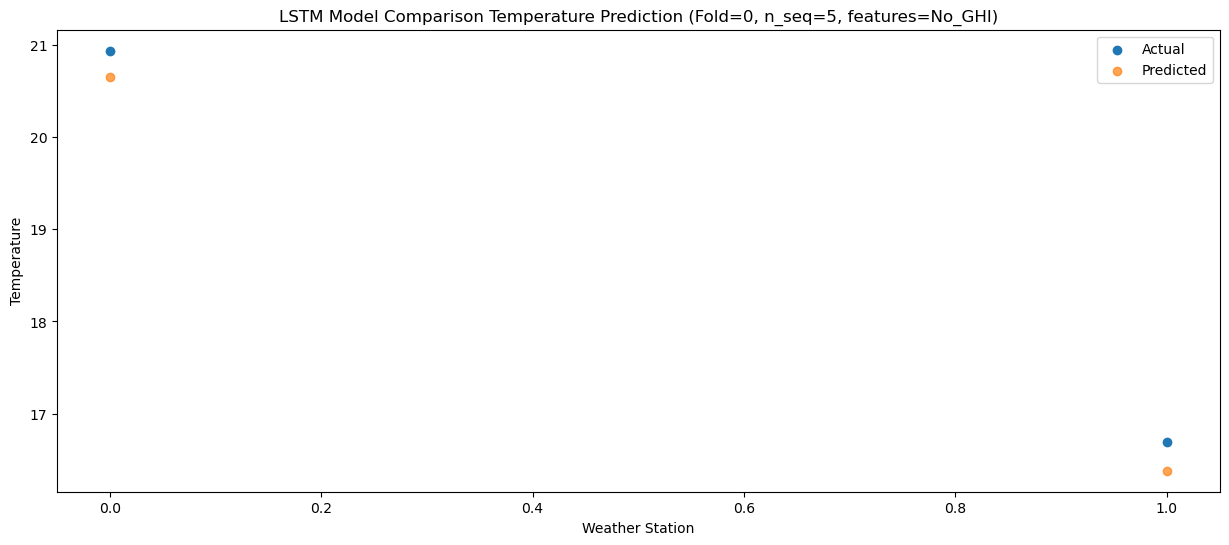

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.77  20.953550
1                1   16.18  16.683619


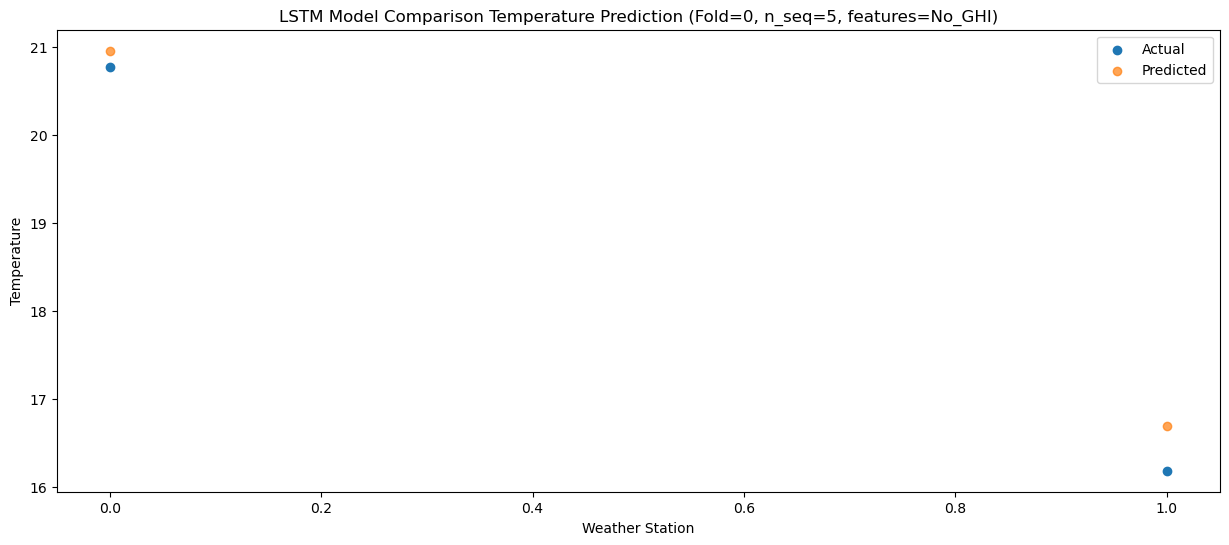

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.01  20.477687
1                1   16.46  16.207743


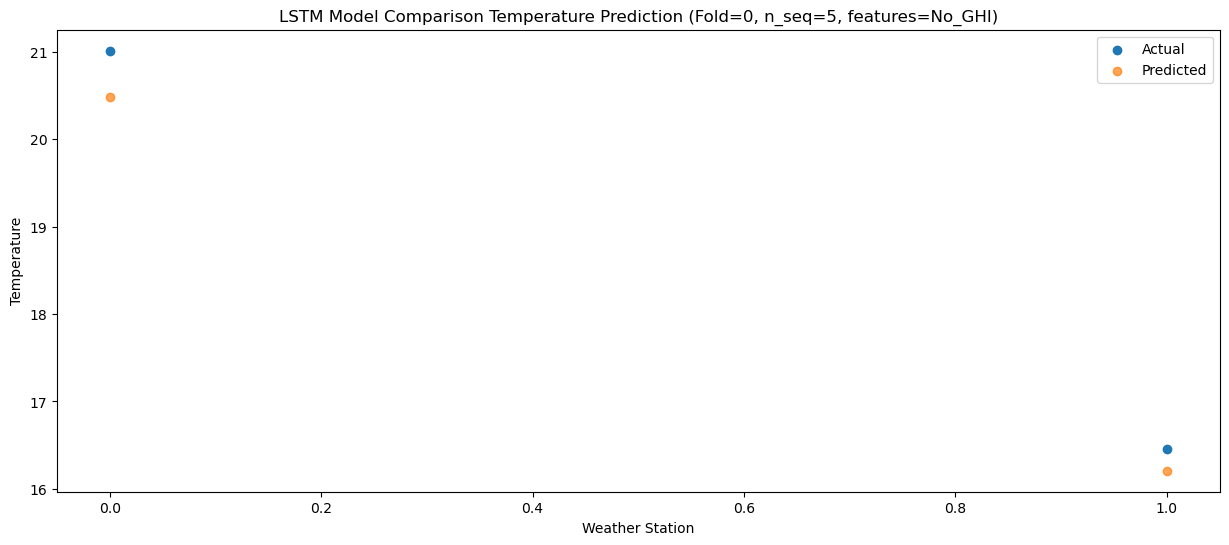

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.43  21.507494
1                1   16.29  17.237554


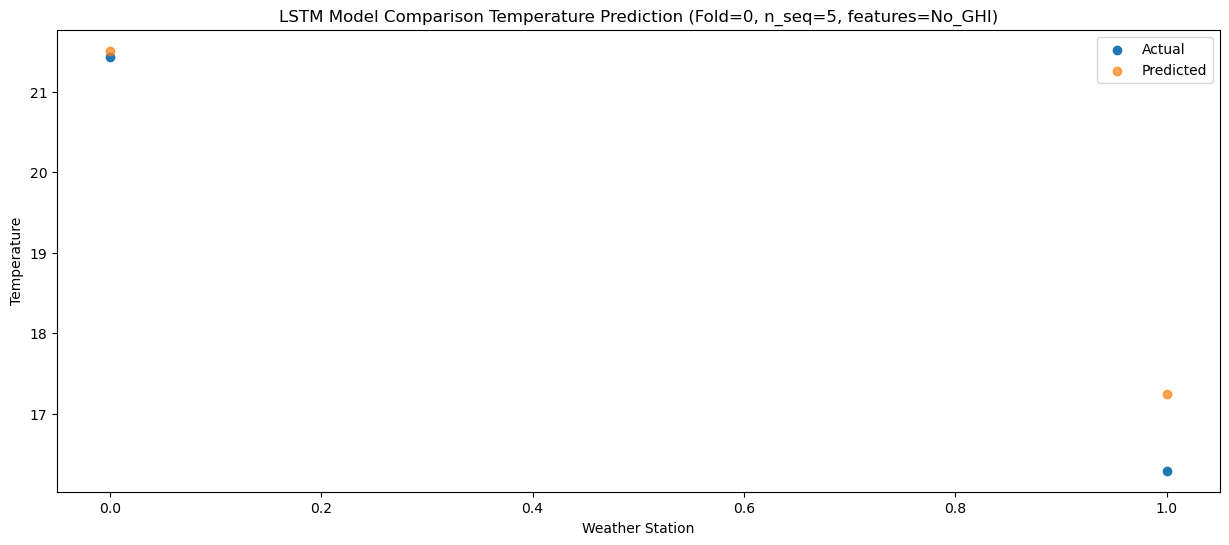

f, t:
[[20.77 17.52]
 [20.94 16.69]
 [20.77 16.18]
 [21.01 16.46]
 [21.43 16.29]]
[[19.32089504 15.05089957]
 [20.64948162 16.37949414]
 [20.95354953 16.68361894]
 [20.47768736 16.20774344]
 [21.50749433 17.23755411]]
Year at t+1:
t+1 SKRMSE: 2.024396
t+1 KRMSE: 2.024396
t+1 MAE: 1.959103
t+1 SKMAPE: 0.105350
t+1 R2_SCORE: -0.551974
t+1 KMAPE: 0.105350
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.300678
t+2 KRMSE: 0.300678
t+2 MAE: 0.300512
t+2 SKMAPE: 0.016239
t+2 R2_SCORE: 0.979979
t+2 KMAPE: 0.016239
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.379027
t+3 KRMSE: 0.379027
t+3 MAE: 0.343584
t+3 SKMAPE: 0.019982
t+3 R2_SCORE: 0.972724
t+3 KMAPE: 0.019982
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.416527
t+4 KRMSE: 0.416527
t+4 MAE: 0.392285
t+4 SKMAPE: 0.020331
t+4 R2_SCORE: 0.966478
t+4 KMAPE: 0.020331
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.672259
t+5 KRMSE: 0.672259
t+5 MAE: 0.512524
t+5 SKMAPE: 0.030892
t+5 R2_SCORE: 0.931576
t+5 KMAPE: 0.030892
t+5 PEARSON: 

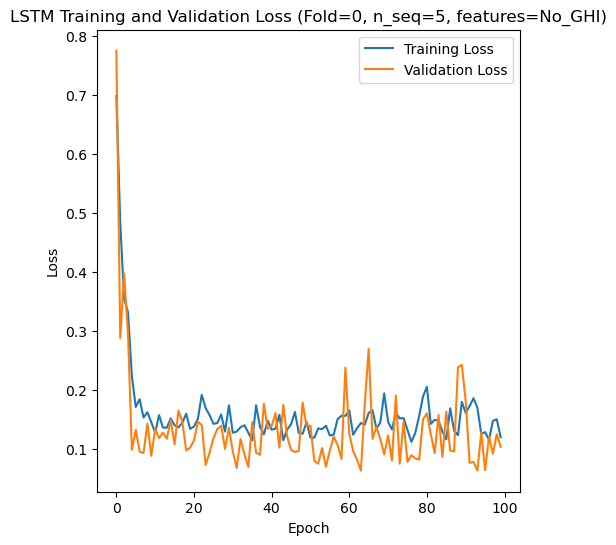

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 9s 193ms/step - loss: 0.7330 - accuracy: 0.4211 - mae: 0.6524 - rmse: 0.7330 - mape: 106.4588 - pearson: 0.1997 - val_loss: 0.6283 - val_accuracy: 0.0000e+00 - val_mae: 0.5248 - val_rmse: 0.6283 - val_mape: 88.8932 - val_pearson: 0.1497
Epoch 2/100
19/19 [==============================] - 1s 48ms/step - loss: 0.4312 - accuracy: 0.2105 - mae: 0.3562 - rmse: 0.4312 - mape: 58.9017 - pearson: 0.2358 - val_loss: 0.4226 - val_accuracy: 0.0000e+00 - val_mae: 0.3862 - val_rmse: 0.4226 - val_mape: 63.1008 - val_pearson: 0.3047
Epoch 3/100
19/19 [==============================] - 1s 57ms/step - loss: 0.2969 - a

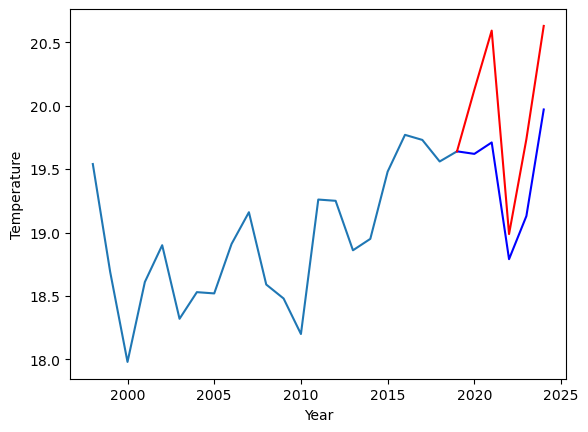

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.82		20.28		0.46
20.34		20.74		0.40
19.95		19.14		-0.81
19.95		19.89		-0.06
21.26		20.78		-0.48


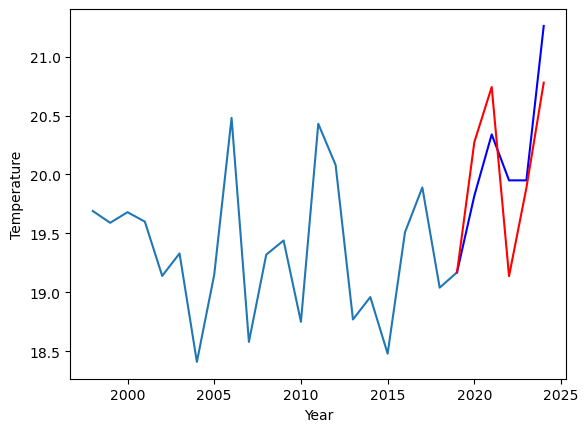

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.62  20.125468
1                1   19.82  20.275454


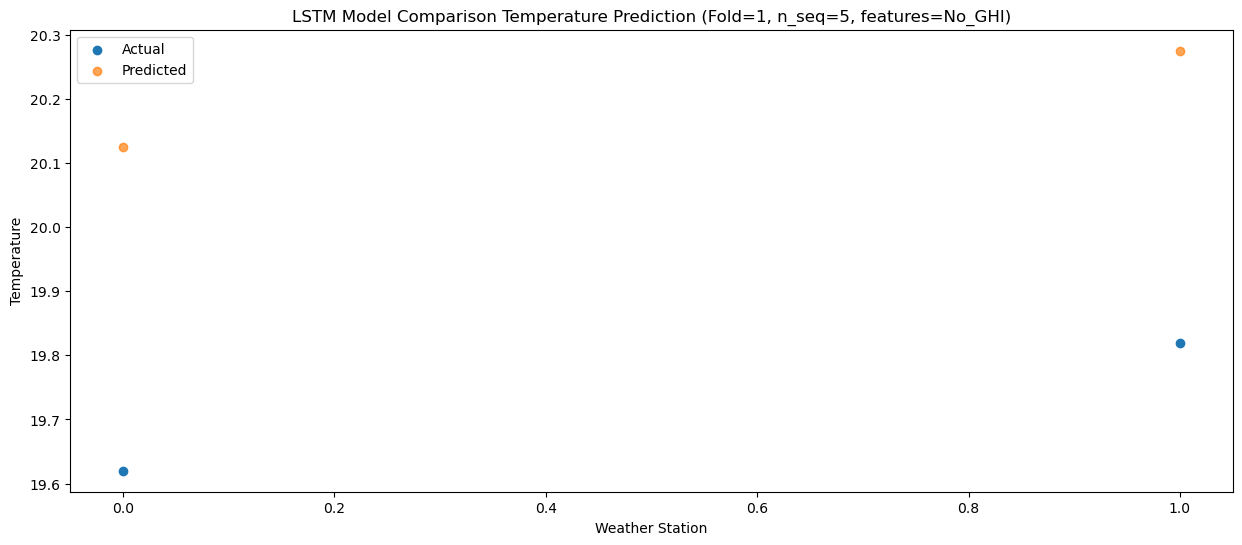

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   19.71   20.59182
1                1   20.34   20.74181


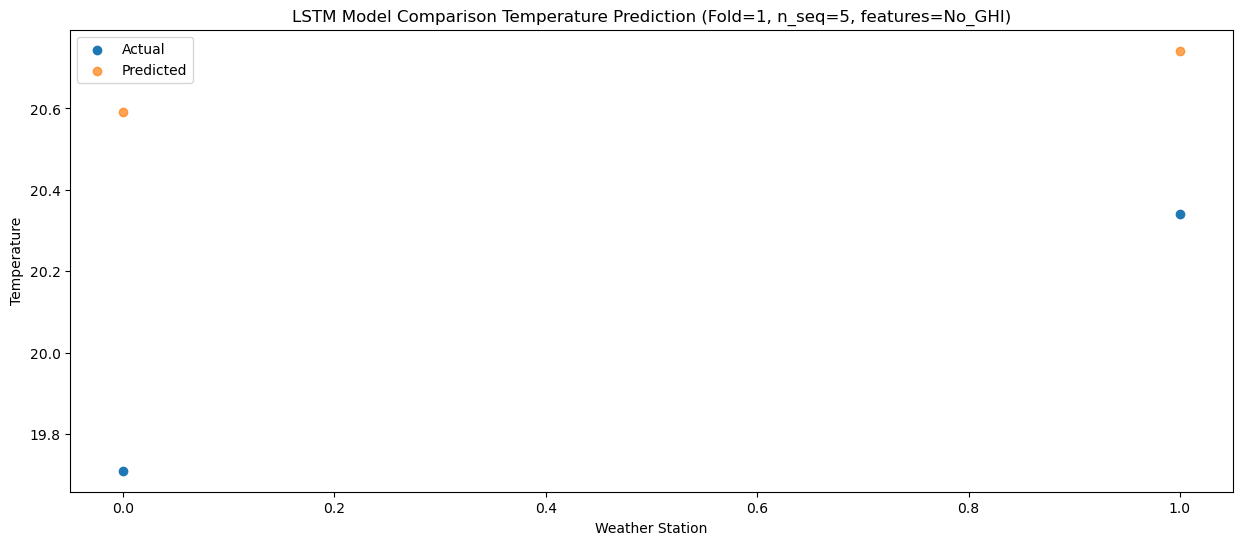

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.79  18.987907
1                1   19.95  19.137880


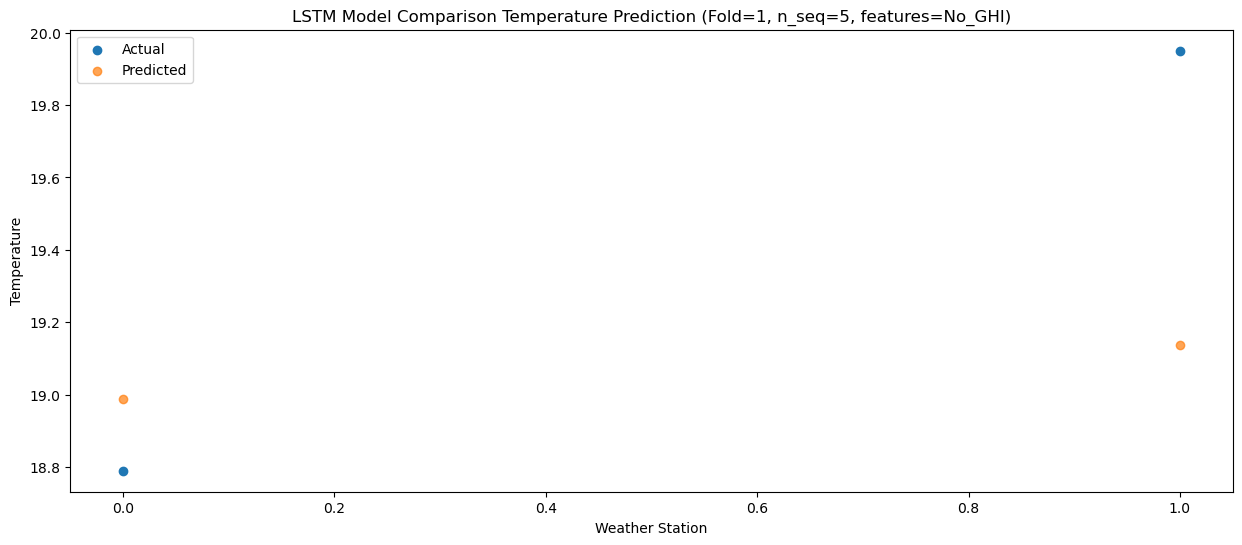

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   19.13  19.736196
1                1   19.95  19.886184


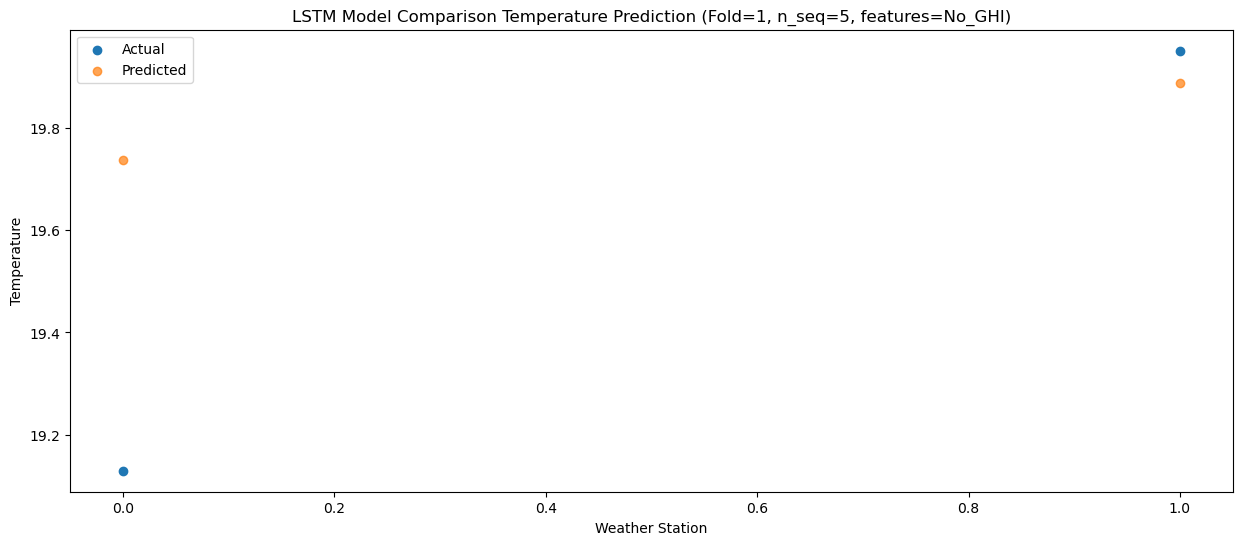

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   19.97  20.628638
1                1   21.26  20.778626


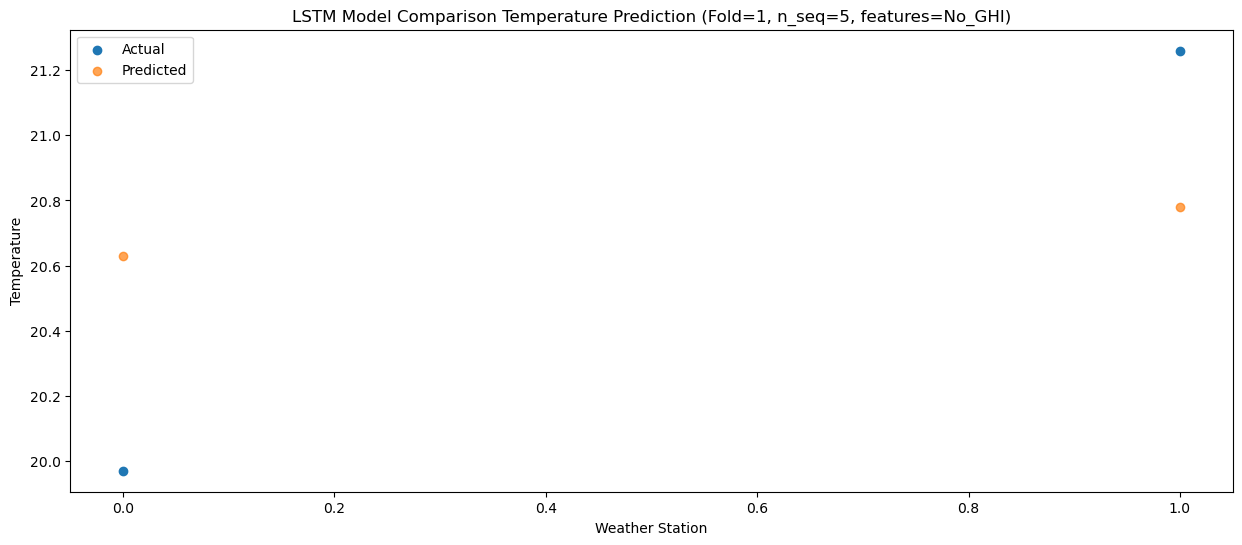

f, t:
[[19.62 19.82]
 [19.71 20.34]
 [18.79 19.95]
 [19.13 19.95]
 [19.97 21.26]]
[[20.12546829 20.27545363]
 [20.59182043 20.74180997]
 [18.98790688 19.13788033]
 [19.73619569 19.88618386]
 [20.62863756 20.77862615]]
Year at t+1:
t+1 SKRMSE: 0.481111
t+1 KRMSE: 0.481111
t+1 MAE: 0.480461
t+1 SKMAPE: 0.024371
t+1 R2_SCORE: -22.146810
t+1 KMAPE: 0.024371
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.685222
t+2 KRMSE: 0.685222
t+2 MAE: 0.641815
t+2 SKMAPE: 0.032247
t+2 R2_SCORE: -3.731965
t+2 KMAPE: 0.032247
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.591061
t+3 KRMSE: 0.591061
t+3 MAE: 0.505013
t+3 SKMAPE: 0.025620
t+3 R2_SCORE: -0.038504
t+3 KMAPE: 0.025620
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.431014
t+4 KRMSE: 0.431014
t+4 MAE: 0.335006
t+4 SKMAPE: 0.017444
t+4 R2_SCORE: -0.105133
t+4 KMAPE: 0.017444
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.576855
t+5 KRMSE: 0.576855
t+5 MAE: 0.570006
t+5 SKMAPE: 0.027812
t+5 R2_SCORE: 0.200139
t+5 KMAPE: 0.027812
t+5 PEARS

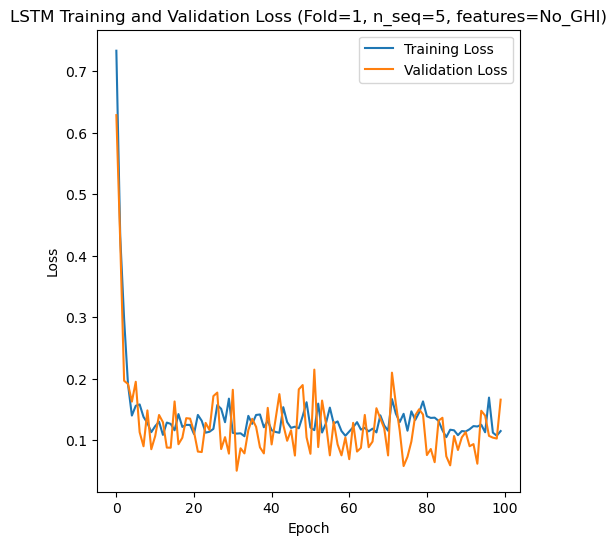

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 6s 114ms/step - loss: 0.5754 - accuracy: 0.2105 - mae: 0.4854 - rmse: 0.5754 - mape: 77.8586 - pearson: 0.3374 - val_loss: 0.4734 - val_accuracy: 0.6667 - val_mae: 0.4208 - val_rmse: 0.4734 - val_mape: 65.4914 - val_pearson: 0.5561
Epoch 2/100
19/19 [==============================] - 1s 46ms/step - loss: 0.5357 - accuracy: 0.2632 - mae: 0.4535 - rmse: 0.5357 - mape: 74.0669 - pearson: 0.2376 - val_loss: 0.4874 - val_accuracy: 0.0000e+00 - val_mae: 0.4327 - val_rmse: 0.4874 - val_mape: 71.0919 - val_pearson: 0.3863
Epoch 3/100
19/19 [==============================] - 1s 47ms/step - loss: 0.4508 - accura

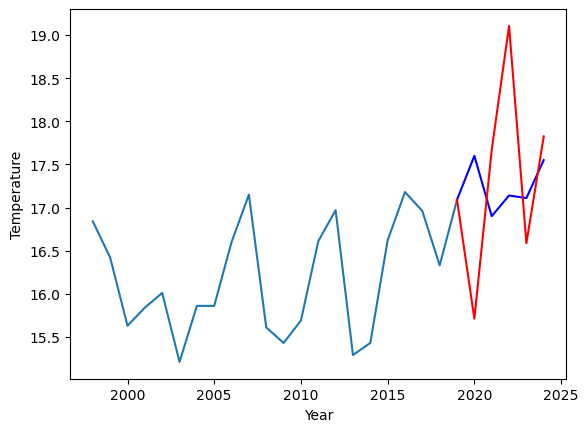

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.84		12.38		-1.46
13.83		14.34		0.51
13.82		15.78		1.96
13.36		13.26		-0.10
14.15		14.50		0.35


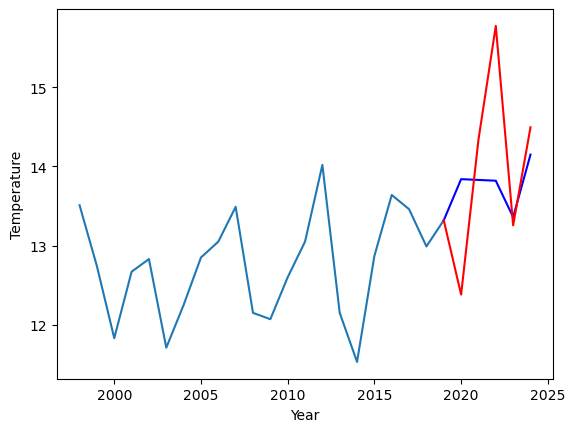

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.60  15.710594
1                1   13.84  12.380627


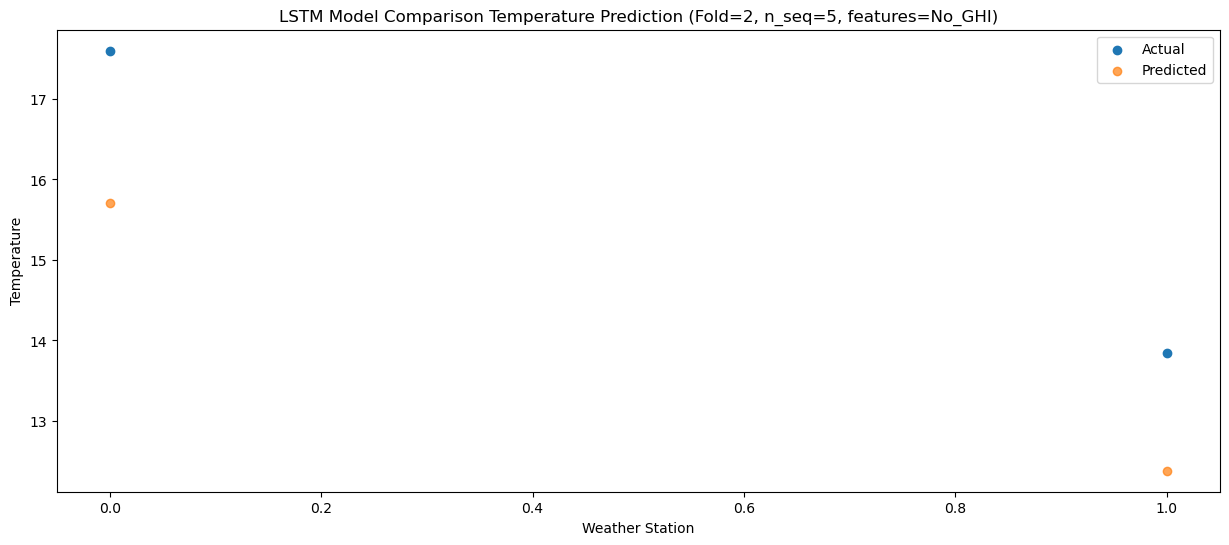

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   16.90  17.667564
1                1   13.83  14.337590


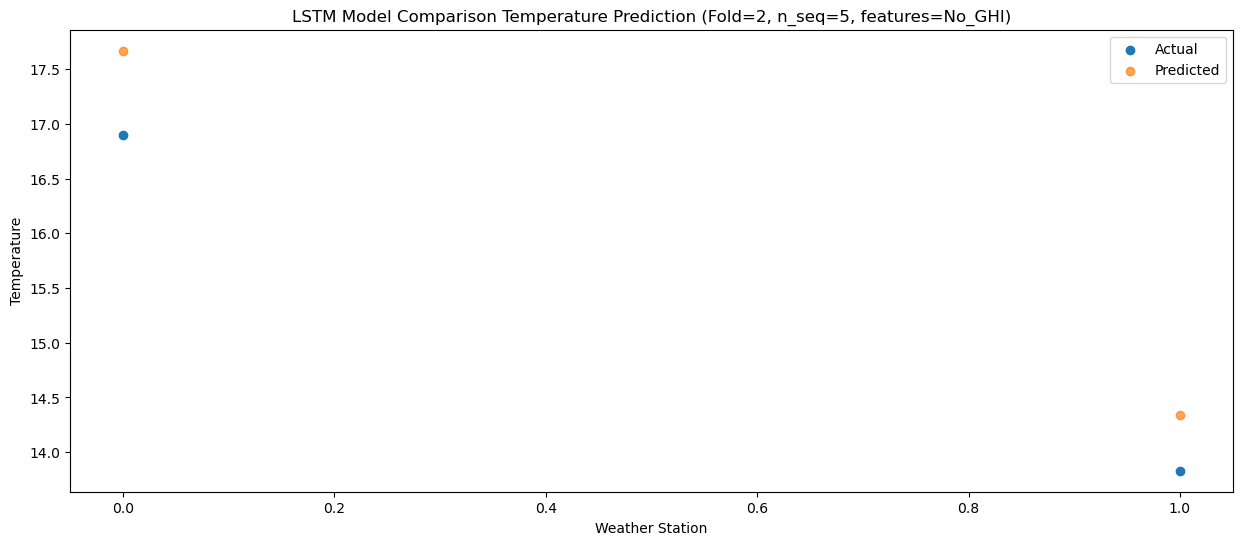

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   17.14  19.106324
1                1   13.82  15.776382


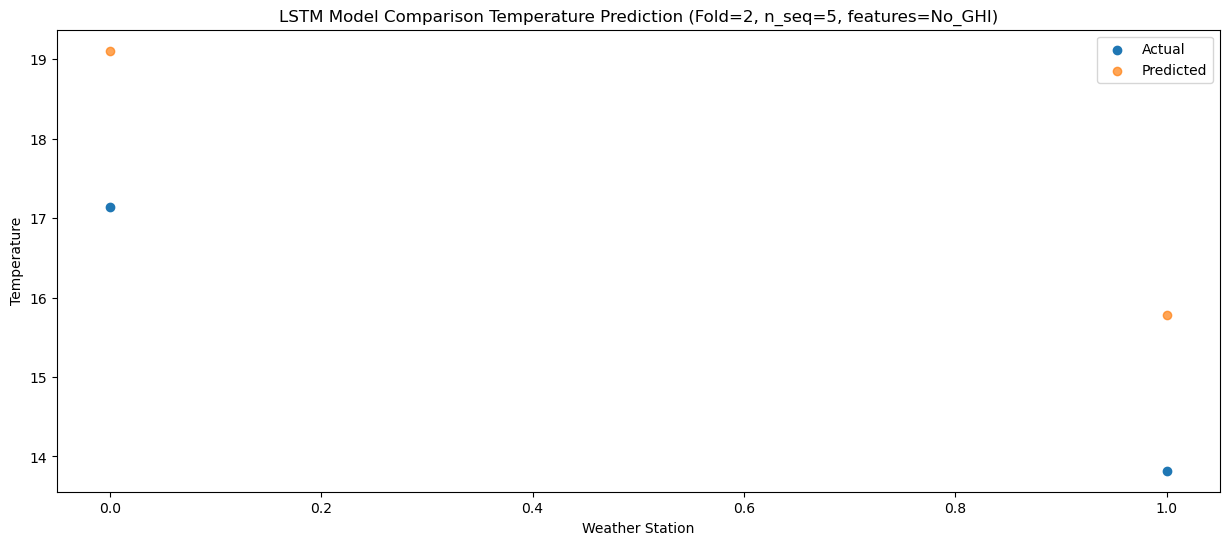

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   17.11  16.586027
1                1   13.36  13.256096


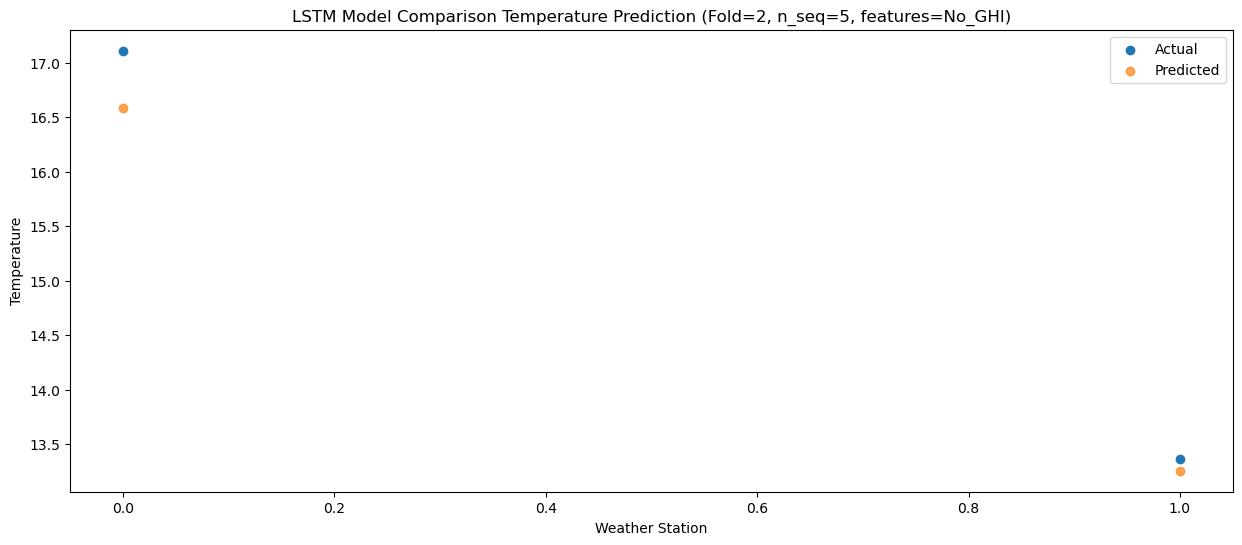

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.55  17.825043
1                1   14.15  14.495140


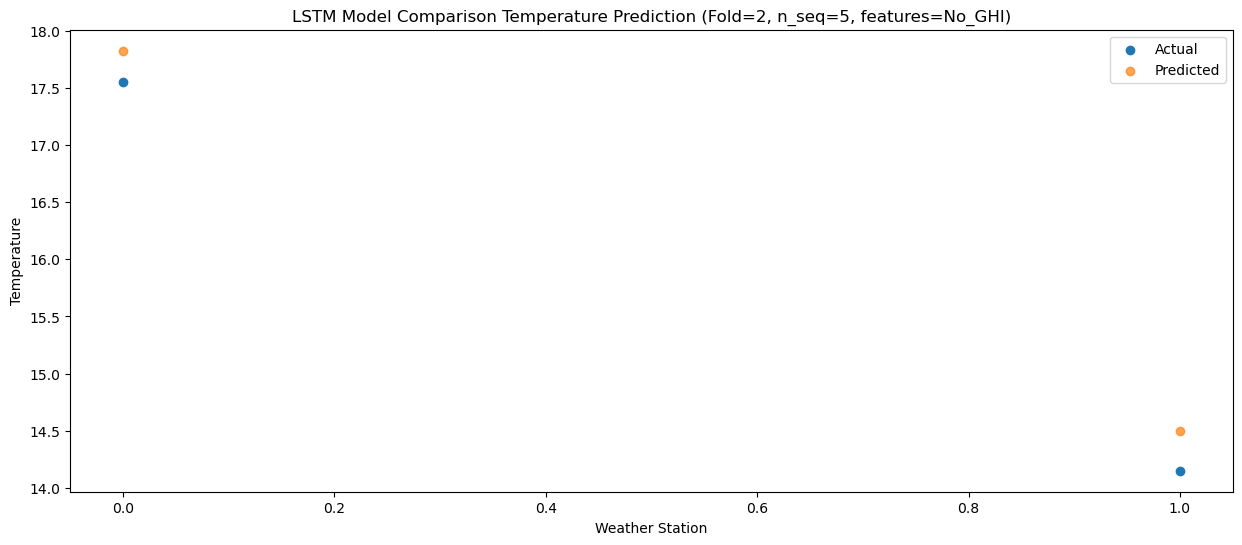

f, t:
[[17.6  13.84]
 [16.9  13.83]
 [17.14 13.82]
 [17.11 13.36]
 [17.55 14.15]]
[[15.71059391 12.38062681]
 [17.66756388 14.33759011]
 [19.10632404 15.77638174]
 [16.58602747 13.25609613]
 [17.82504329 14.49513973]]
Year at t+1:
t+1 SKRMSE: 1.688139
t+1 KRMSE: 1.688139
t+1 MAE: 1.674390
t+1 SKMAPE: 0.106399
t+1 R2_SCORE: 0.193693
t+1 KMAPE: 0.106399
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.650693
t+2 KRMSE: 0.650693
t+2 MAE: 0.637577
t+2 SKMAPE: 0.041060
t+2 R2_SCORE: 0.820305
t+2 KMAPE: 0.041060
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.961359
t+3 KRMSE: 1.961359
t+3 MAE: 1.961353
t+3 SKMAPE: 0.128141
t+3 R2_SCORE: -0.396041
t+3 KMAPE: 0.128141
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.377719
t+4 KRMSE: 0.377719
t+4 MAE: 0.313938
t+4 SKMAPE: 0.019200
t+4 R2_SCORE: 0.959418
t+4 KMAPE: 0.019200
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.312066
t+5 KRMSE: 0.312066
t+5 MAE: 0.310092
t+5 SKMAPE: 0.020032
t+5 R2_SCORE: 0.966303
t+5 KMAPE: 0.020032
t+5 PEARSON: 

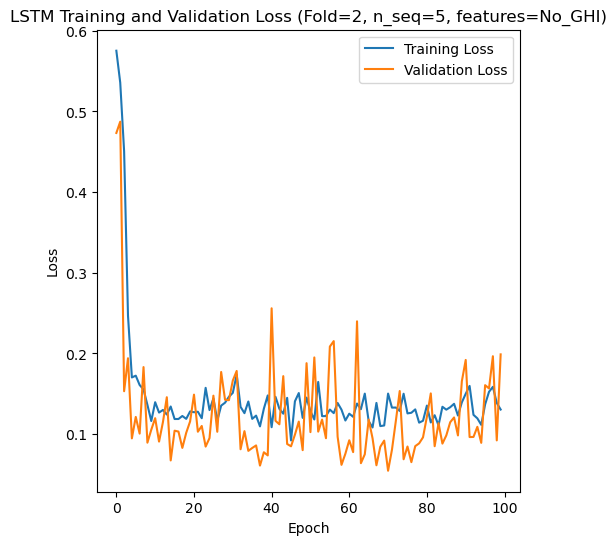

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 6s 110ms/step - loss: 0.7843 - accuracy: 0.2500 - mae: 0.6863 - rmse: 0.7843 - mape: 108.2136 - pearson: 0.2071 - val_loss: 0.7244 - val_accuracy: 0.0000e+00 - val_mae: 0.6273 - val_rmse: 0.7244 - val_mape: 100.7299 - val_pearson: 0.0269
Epoch 2/100
20/20 [==============================] - 1s 43ms/step - loss: 0.4040 - accuracy: 0.2000 - mae: 0.3379 - rmse: 0.4040 - mape: 53.1979 - pearson: 0.3234 - val_loss: 0.3918 - val_accuracy: 0.0000e+00 - val_mae: 0.3507 - val_rmse: 0.3918 - val_mape: 57.4081 - val_pearson: 0.8255
Epoch 3/100
20/20 [==============================] - 1s 44ms/step - loss: 0.2562 - a

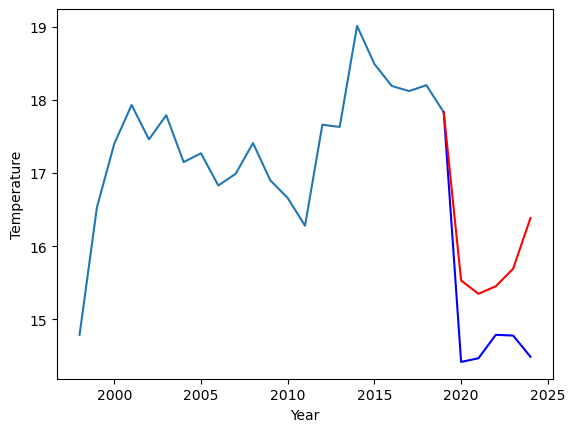

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.47		14.80		0.33
14.35		14.62		0.27
14.15		14.72		0.57
13.85		14.96		1.11
14.87		15.66		0.79


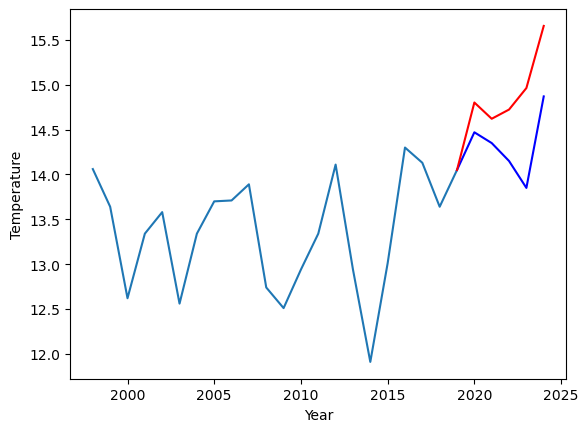

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   14.42  15.532067
1                1   14.47  14.802063


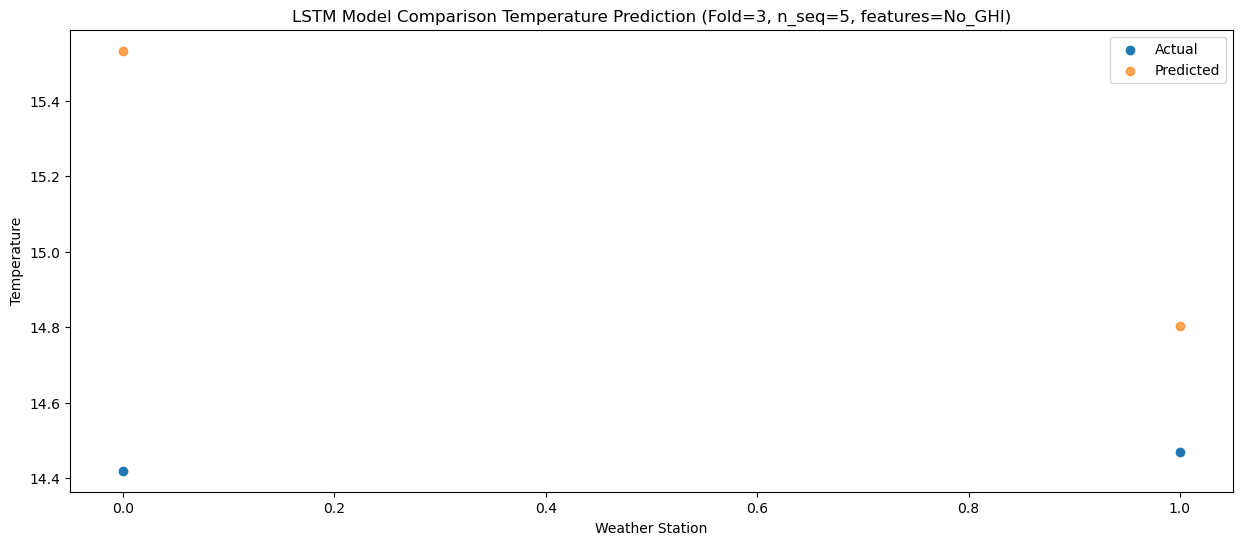

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   14.47  15.350904
1                1   14.35  14.620889


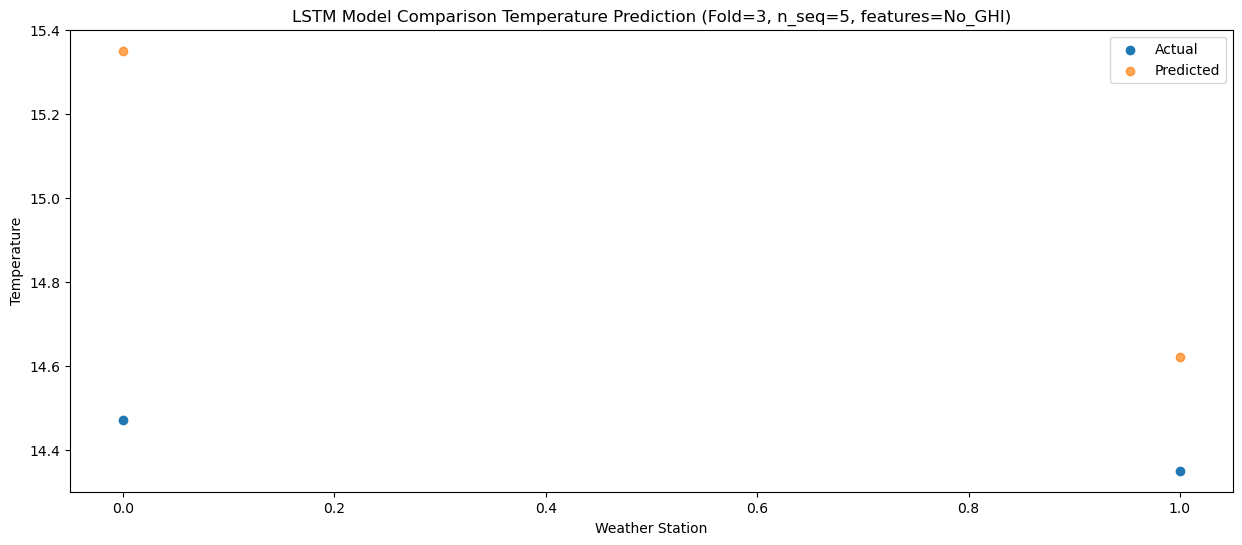

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   14.79  15.453483
1                1   14.15  14.723468


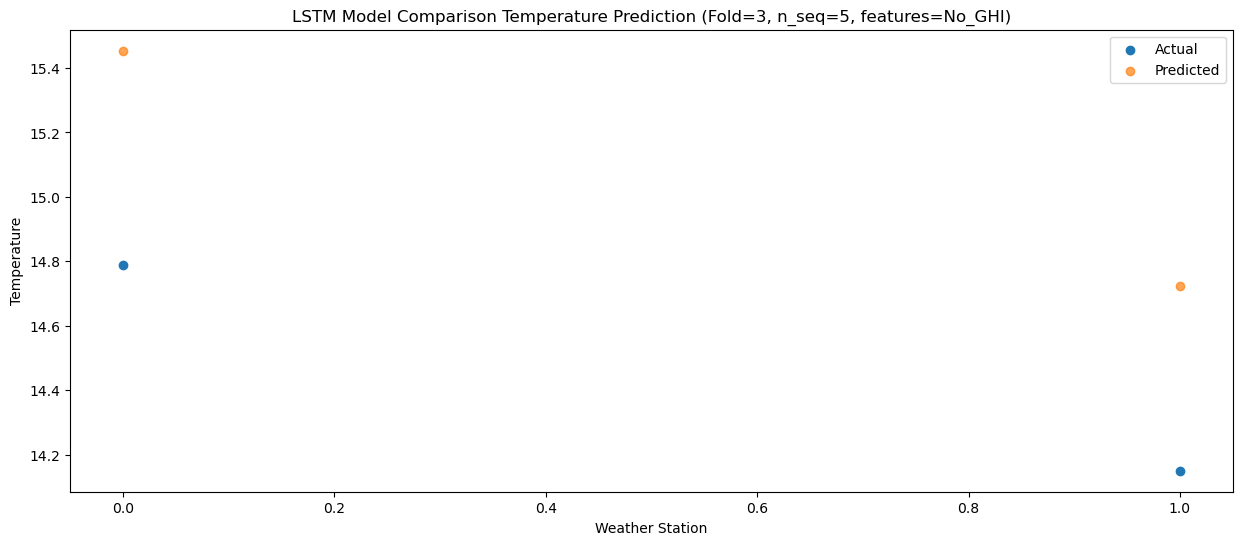

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.78  15.693285
1                1   13.85  14.963259


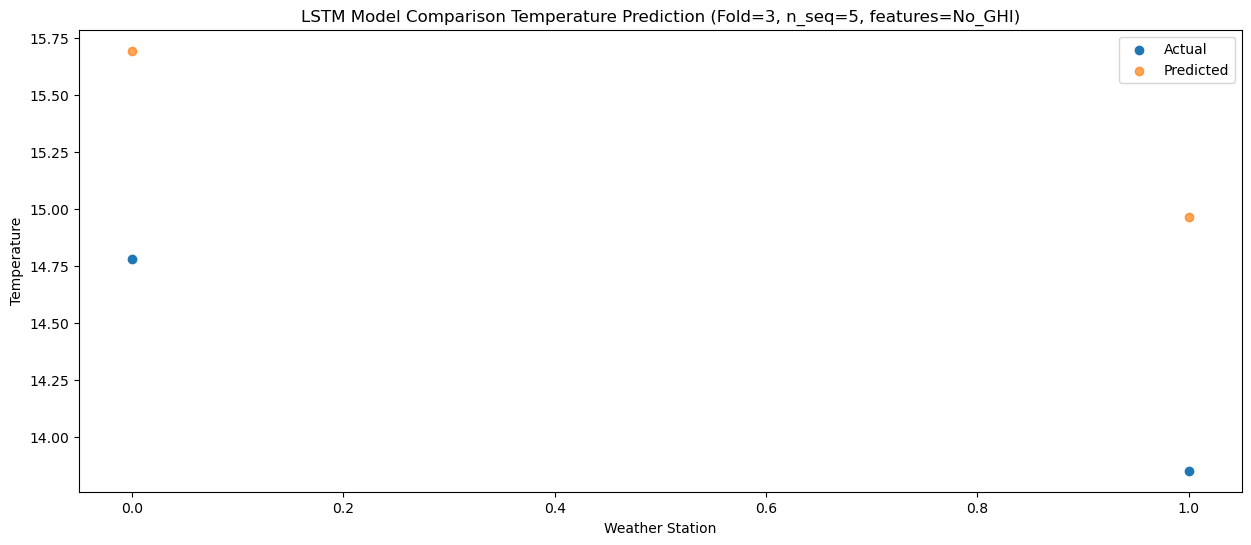

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   14.49  16.385847
1                1   14.87  15.655834


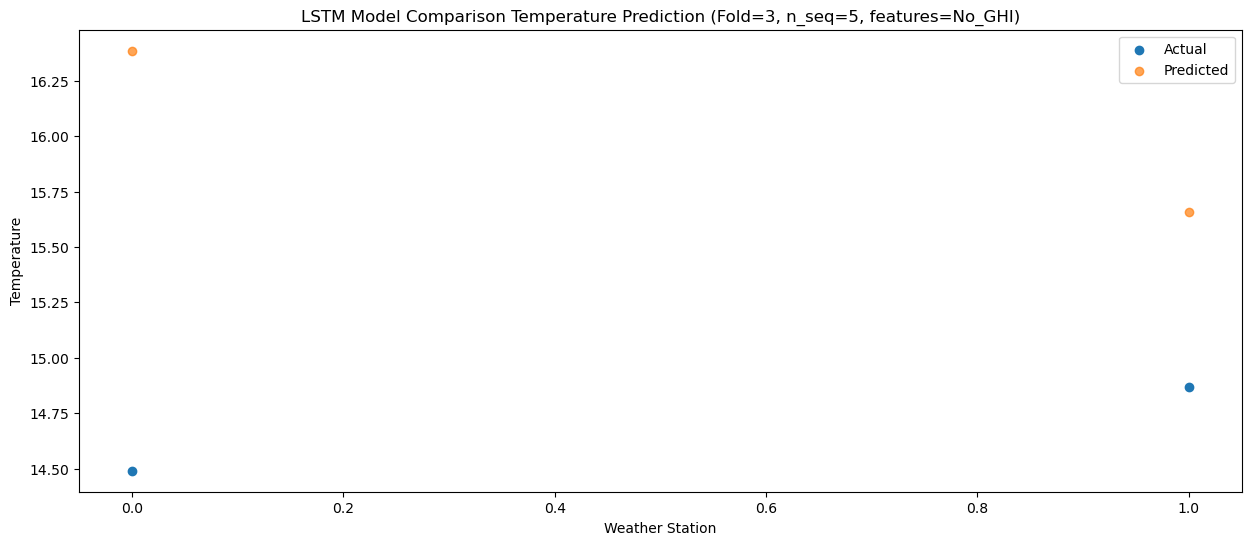

f, t:
[[14.42 14.47]
 [14.47 14.35]
 [14.79 14.15]
 [14.78 13.85]
 [14.49 14.87]]
[[15.53206704 14.80206257]
 [15.35090361 14.62088901]
 [15.4534834  14.7234684 ]
 [15.69328509 14.96325914]
 [16.38584738 15.65583358]]
Year at t+1:
t+1 SKRMSE: 0.820658
t+1 KRMSE: 0.820658
t+1 MAE: 0.722065
t+1 SKMAPE: 0.050034
t+1 R2_SCORE: -1076.566919
t+1 KMAPE: 0.050034
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.651679
t+2 KRMSE: 0.651679
t+2 MAE: 0.575896
t+2 SKMAPE: 0.039878
t+2 R2_SCORE: -116.968336
t+2 KMAPE: 0.039878
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.620111
t+3 KRMSE: 0.620111
t+3 MAE: 0.618476
t+3 SKMAPE: 0.042694
t+3 R2_SCORE: -2.755255
t+3 KMAPE: 0.042694
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.018193
t+4 KRMSE: 1.018193
t+4 MAE: 1.013272
t+4 SKMAPE: 0.071086
t+4 R2_SCORE: -3.794625
t+4 KMAPE: 0.071086
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.451167
t+5 KRMSE: 1.451167
t+5 MAE: 1.340840
t+5 SKMAPE: 0.091843
t+5 R2_SCORE: -57.334788
t+5 KMAPE: 0.091843
t+5

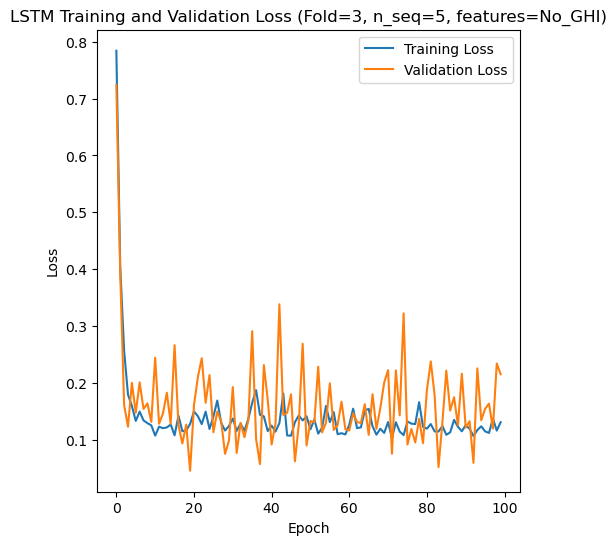

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 6s 113ms/step - loss: 0.6599 - accuracy: 0.1579 - mae: 0.5876 - rmse: 0.6599 - mape: 96.1969 - pearson: 0.1710 - val_loss: 0.5416 - val_accuracy: 0.0000e+00 - val_mae: 0.4563 - val_rmse: 0.5416 - val_mape: 91.3978 - val_pearson: 0.0799
Epoch 2/100
19/19 [==============================] - 1s 44ms/step - loss: 0.5383 - accuracy: 0.1579 - mae: 0.4565 - rmse: 0.5383 - mape: 75.2395 - pearson: 0.2964 - val_loss: 0.3088 - val_accuracy: 1.0000 - val_mae: 0.2558 - val_rmse: 0.3088 - val_mape: 47.3858 - val_pearson: 0.2642
Epoch 3/100
19/19 [==============================] - 1s 43ms/step - loss: 0.3559 - accur

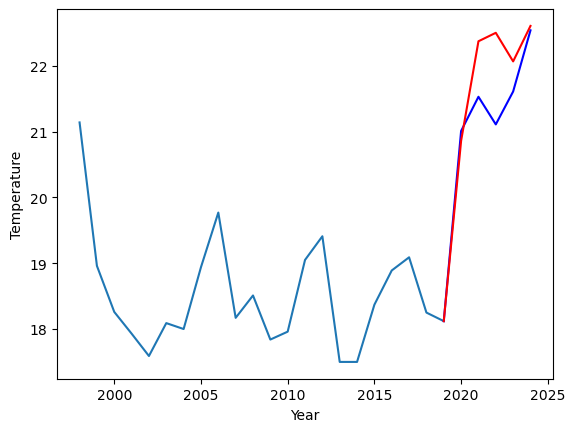

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.23		12.65		0.42
12.79		14.16		1.37
13.11		14.29		1.18
12.24		13.86		1.62
13.72		14.40		0.68


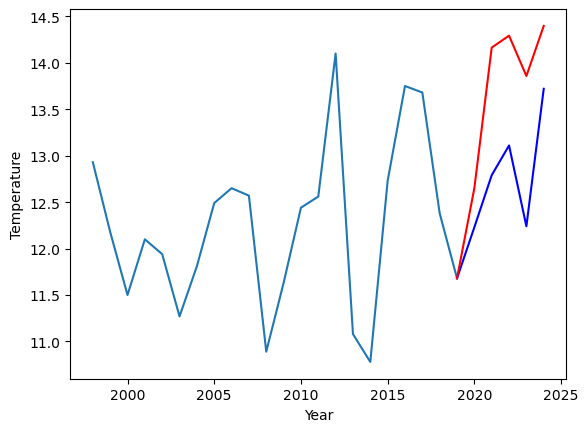

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.01  20.860958
1                1   12.23  12.650955


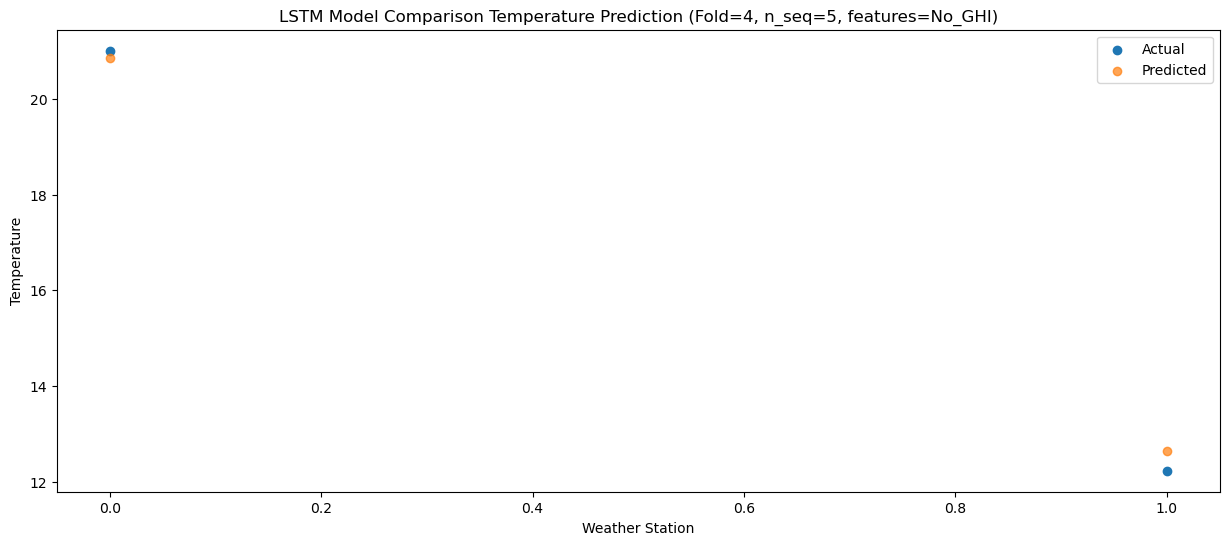

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.53  22.373630
1                1   12.79  14.163624


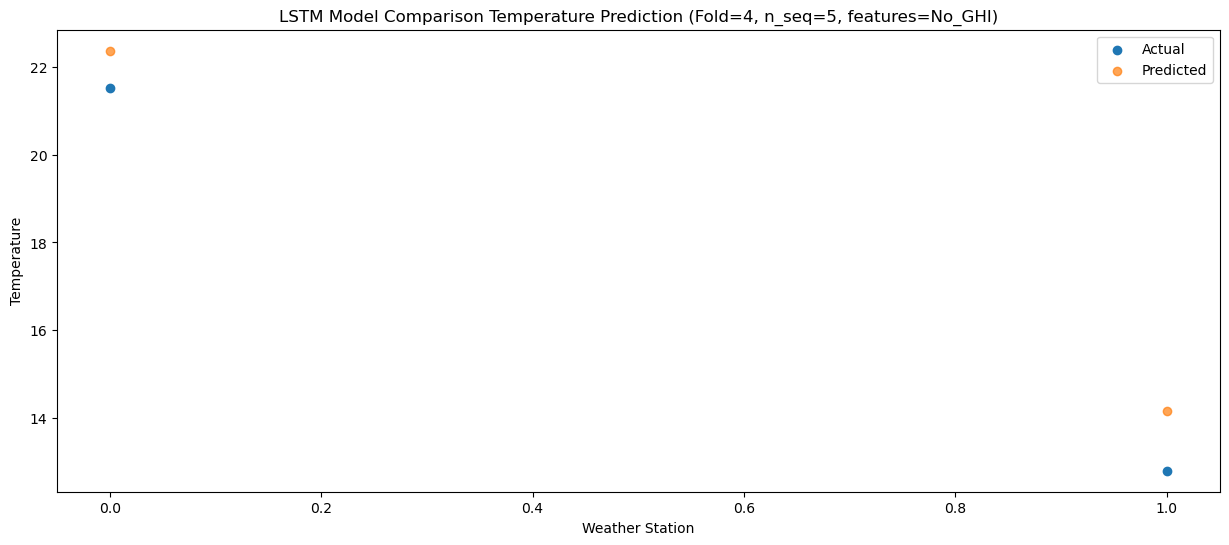

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   21.11  22.502146
1                1   13.11  14.292148


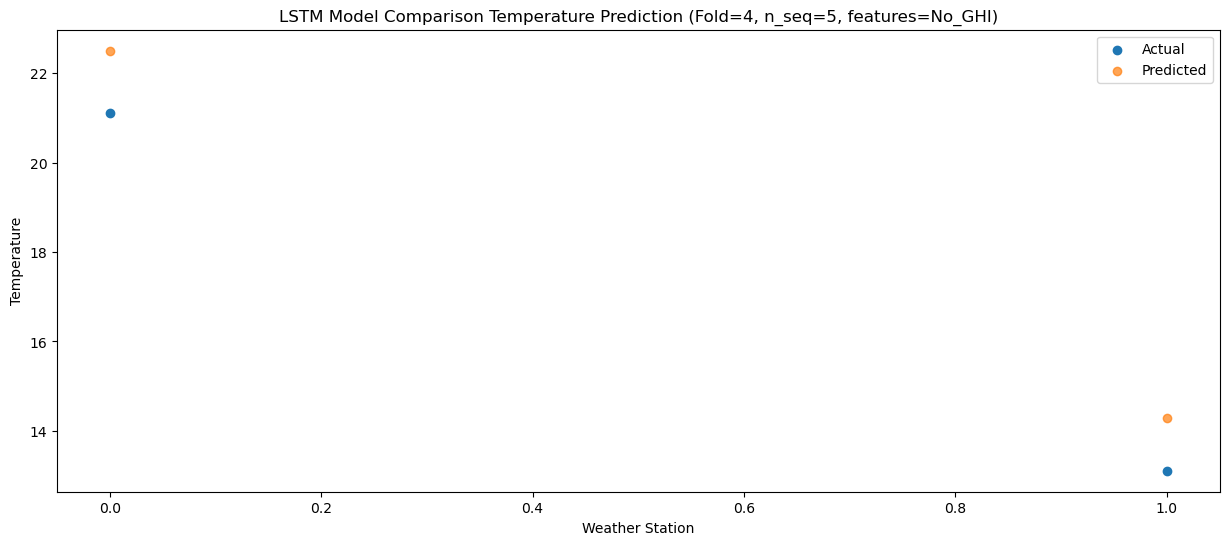

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.61  22.067543
1                1   12.24  13.857545


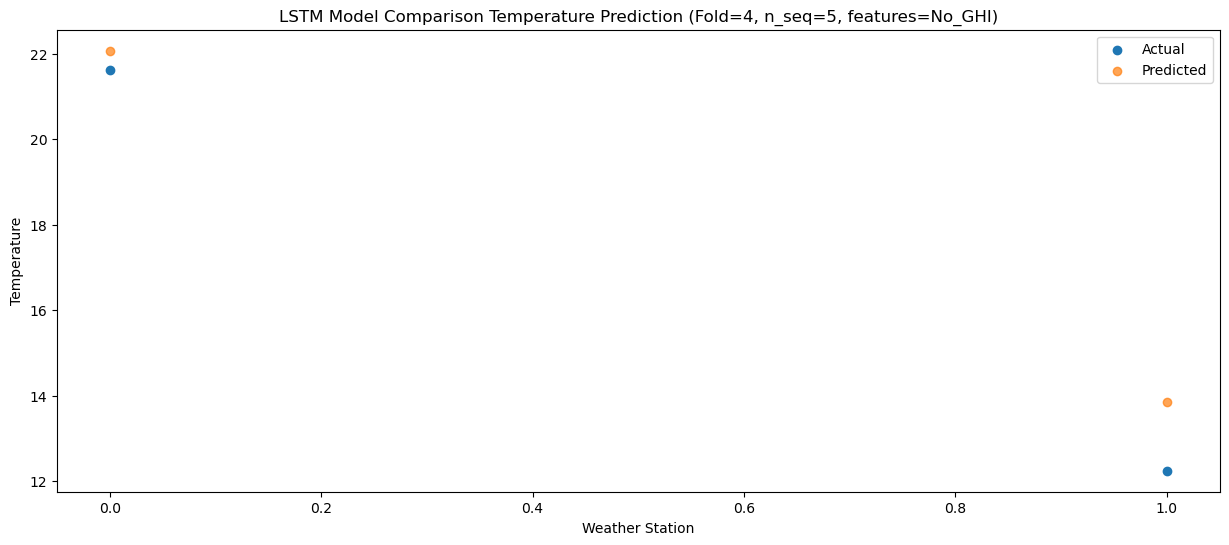

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   22.54  22.606855
1                1   13.72  14.396857


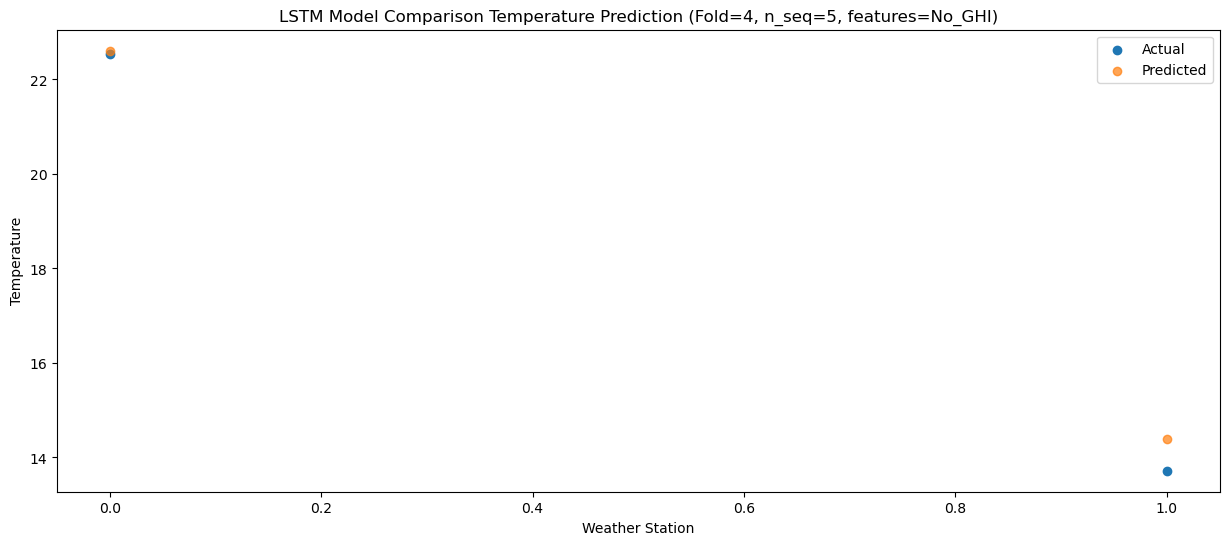

f, t:
[[21.01 12.23]
 [21.53 12.79]
 [21.11 13.11]
 [21.61 12.24]
 [22.54 13.72]]
[[20.86095844 12.65095507]
 [22.37363027 14.1636244 ]
 [22.50214563 14.29214773]
 [22.06754251 13.85754544]
 [22.60685511 14.39685715]]
Year at t+1:
t+1 SKRMSE: 0.315766
t+1 KRMSE: 0.315766
t+1 MAE: 0.284998
t+1 SKMAPE: 0.020757
t+1 R2_SCORE: 0.994826
t+1 KMAPE: 0.020757
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 1.139859
t+2 KRMSE: 1.139859
t+2 MAE: 1.108627
t+2 SKMAPE: 0.073291
t+2 R2_SCORE: 0.931964
t+2 KMAPE: 0.073291
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.291422
t+3 KRMSE: 1.291422
t+3 MAE: 1.287147
t+3 SKMAPE: 0.078059
t+3 R2_SCORE: 0.895764
t+3 KMAPE: 0.078059
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.188654
t+4 KRMSE: 1.188654
t+4 MAE: 1.037544
t+4 SKMAPE: 0.076663
t+4 R2_SCORE: 0.935629
t+4 KMAPE: 0.076663
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.480939
t+5 KRMSE: 0.480939
t+5 MAE: 0.371856
t+5 SKMAPE: 0.026150
t+5 R2_SCORE: 0.988107
t+5 KMAPE: 0.026150
t+5 PEARSON: 1

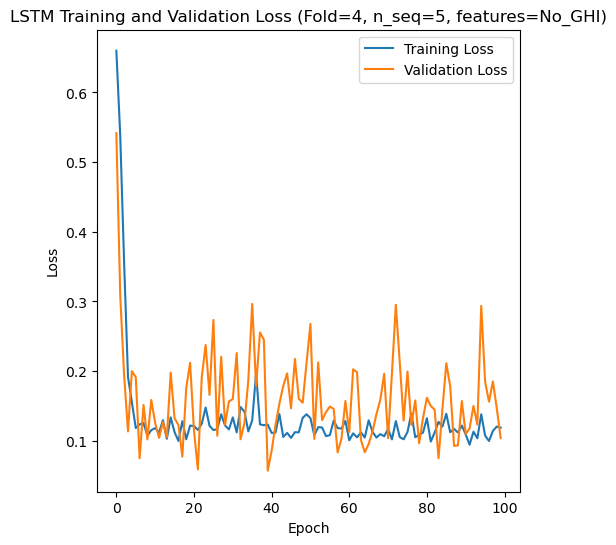

[[0.9957586891760928], [0.5601580271429253], [1.2132765868385655], [0.961801130656125], [0.9706656953664314]]
[[array(0.99575869)], [array(0.56015803)], [array(1.21327659)], [array(0.96180113)], [array(0.9706657)]]
[[0.7016015735864631], [0.5064602115154262], [0.9794698472023009], [0.8541099206209186], [0.8180344876647003]]
[[0.038558652410687885], [0.025498774908846923], [0.06296662095546524], [0.059106831155682285], [0.05498394339999688]]
[[0.7971185172174676], [0.21118743998588851], [0.5191642844919555], [-9.728583862165994], [0.9514596019209429]]
[[array(0.03855865)], [array(0.02549877)], [array(0.06296662)], [array(0.05910683)], [array(0.05498394)]]
[[array(0.8346925)], [array(0.44396512)], [array(0.65295217)], [array(0.27526383)], [array(0.98597556)]]
[[[19.320895042419433, 20.649481620788574, 20.953549530506134, 20.477687355279922, 21.50749432682991], [15.050899572372437, 16.379494137763977, 16.683618940114975, 16.207743443250656, 17.23755411028862]], [[20.125468292236327, 20.59

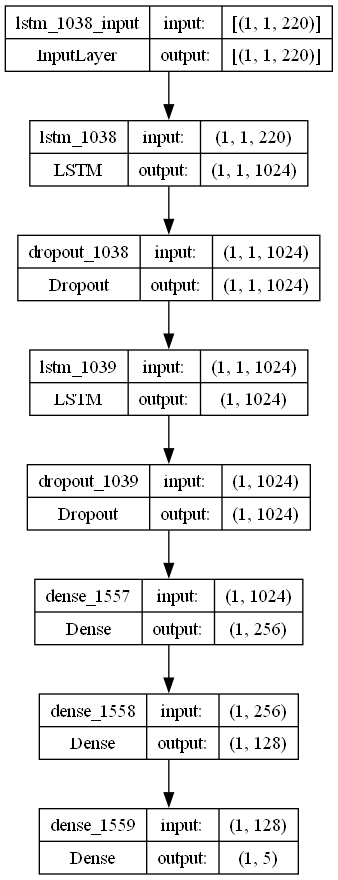

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.0022010975910560578
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.4219890267436188

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S5_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [7]:
print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

[[0.9957586891760928], [0.5601580271429253], [1.2132765868385655], [0.961801130656125], [0.9706656953664314]]
[[array(0.99575869)], [array(0.56015803)], [array(1.21327659)], [array(0.96180113)], [array(0.9706657)]]
[[0.7016015735864631], [0.5064602115154262], [0.9794698472023009], [0.8541099206209186], [0.8180344876647003]]
[[0.038558652410687885], [0.025498774908846923], [0.06296662095546524], [0.059106831155682285], [0.05498394339999688]]
[[0.7971185172174676], [0.21118743998588851], [0.5191642844919555], [-9.728583862165994], [0.9514596019209429]]
[[array(0.03855865)], [array(0.02549877)], [array(0.06296662)], [array(0.05910683)], [array(0.05498394)]]
[[array(0.8346925)], [array(0.44396512)], [array(0.65295217)], [array(0.27526383)], [array(0.98597556)]]
[20.77 20.94 20.77 21.01 21.43 17.52 16.69 16.18 16.46 16.29 19.62 19.71
 18.79 19.13 19.97 19.82 20.34 19.95 19.95 21.26 17.6  16.9  17.14 17.11
 17.55 13.84 13.83 13.82 13.36 14.15 14.42 14.47 14.79 14.78 14.49 14.47
 14.35 14.15 